# Imports

In [71]:
%matplotlib inline
import numpy as np
import math
import torch
import time
from mpl_toolkits import mplot3d
from matplotlib import pyplot as plt
from torch.optim import lr_scheduler

## Goal of Optimization

We model f(x) as the risk function and g(x) as the empirical risk function

In [2]:
def f(x):
    return x * torch.cos(np.pi * x)

def g(x):
    return f(x) + 0.2 * torch.cos(5 * np.pi * x)

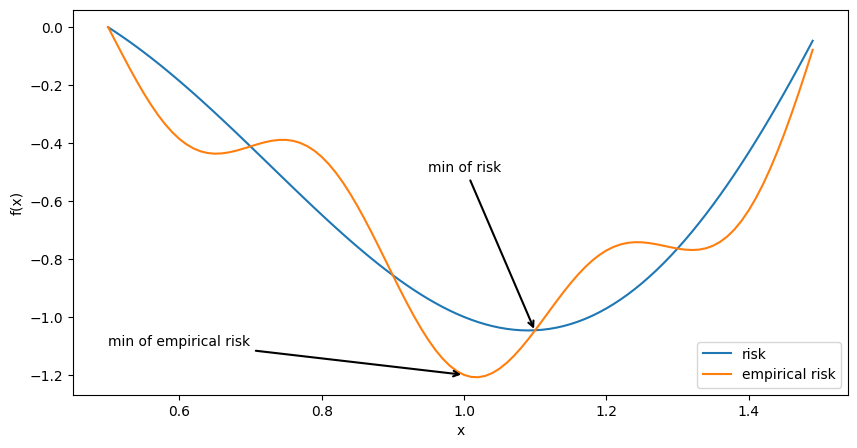

In [3]:
def annotate(text, xy, xytext):
    plt.gca().annotate(text, xy=xy, xytext=xytext, arrowprops=dict(arrowstyle='->', lw=1.5))

x = torch.arange(0.5, 1.5, 0.01)
plt.figure(figsize=(10, 5))
plt.plot(x, f(x), label='risk')
plt.plot(x, g(x), label='empirical risk')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
annotate('min of empirical risk', (1.0, -1.2), (0.5, -1.1))
annotate('min of risk', (1.1, -1.05), (0.95, -0.5))

# Optimization Challenges

## Local Minima

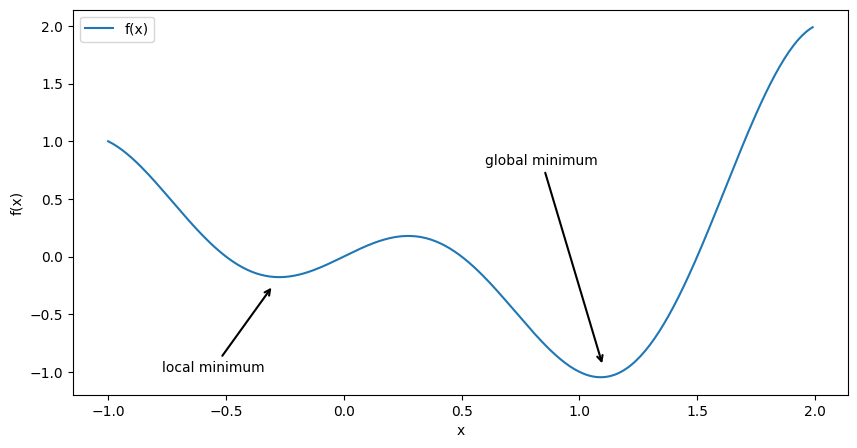

In [4]:
x = torch.arange(-1.0, 2.0, 0.01)
plt.figure(figsize=(10, 5))
plt.plot(x, f(x), label='f(x)')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
annotate('local minimum', (-0.3, -0.25), (-0.77, -1.0))
annotate('global minimum', (1.1, -0.95), (0.6, 0.8))

## Saddle Points

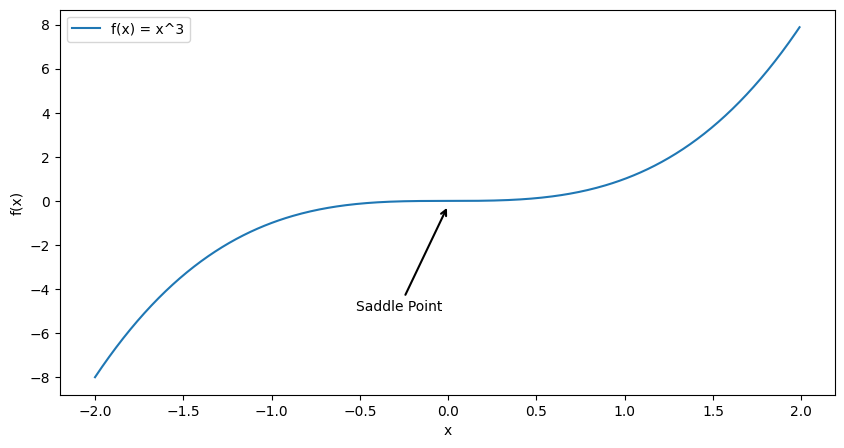

In [5]:
x = torch.arange(-2.0, 2.0, 0.01)
plt.figure(figsize=(10, 5))
plt.plot(x, x**3, label='f(x) = x^3')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
annotate('Saddle Point', (0, -0.2), (-0.52, -5.0))

Saddle points in higher dimensions

c:\Users\Ishaan\Desktop\Personal Projects\Deep-Learning\.venv\lib\site-packages\torch\functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:4324.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Text(0.5, 0.5, 'y')

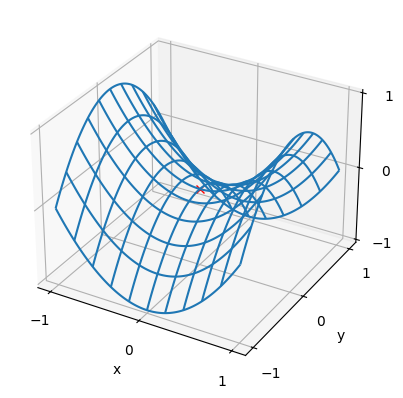

In [6]:
x, y = torch.meshgrid(
    torch.linspace(-1.0, 1.0, 101), torch.linspace(-1.0, 1.0, 101))
z = x**2 - y**2

ax = plt.figure().add_subplot(111, projection='3d')
ax.plot_wireframe(x, y, z, **{'rstride': 10, 'cstride': 10})
ax.plot([0], [0], [0], 'rx')
ticks = [-1, 0, 1]
plt.xticks(ticks)
plt.yticks(ticks)
ax.set_zticks(ticks)
plt.xlabel('x')
plt.ylabel('y')

To differentiate between local minima, local maxima and saddle points in high dimensional data, we look at the hessian matrix at the zero-gradient position

## Vanishing Gradients

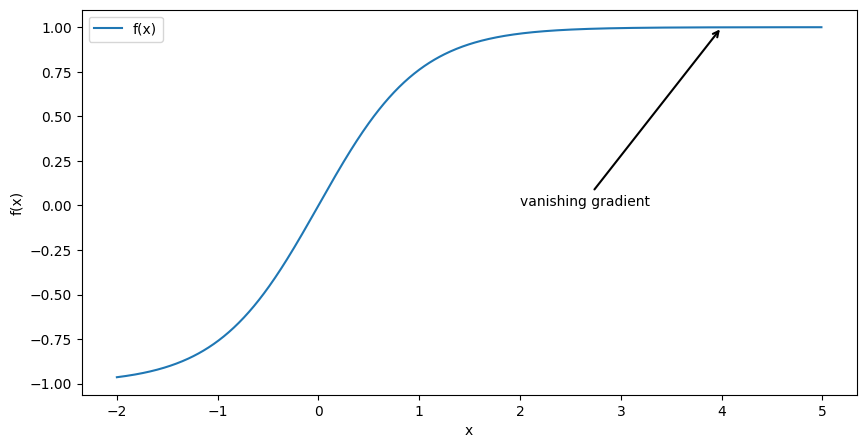

In [7]:
x = torch.arange(-2.0, 5.0, 0.01)
plt.figure(figsize=(10, 5))
plt.plot(x, torch.tanh(x), label = 'f(x)')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
annotate('vanishing gradient', (4, 1), (2, 0.0))

# Convexity

## Convex Functions

In [8]:
f = lambda x: 0.5 * x**2 # Convex
g = lambda x: torch.cos(np.pi * x) # Non-convex
h = lambda x: torch.exp(0.5 * x) # Convex

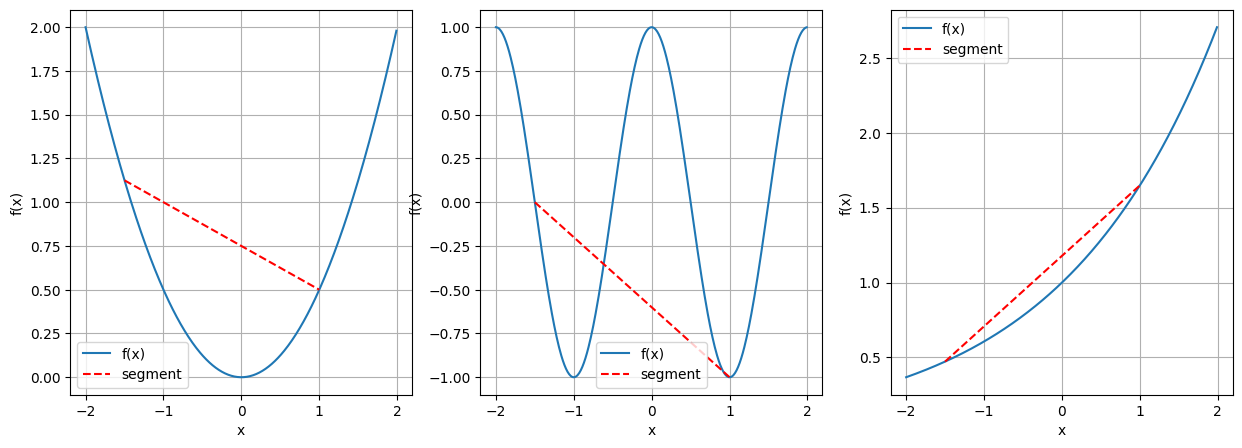

In [9]:
x, segment = torch.arange(-2, 2, 0.01), torch.tensor([-1.5, 1])
_, ax = plt.subplots(1, 3, figsize=(15, 5))
for ax, func in zip(ax, [f, g, h]):
    ax.plot(x, func(x), label='f(x)')
    ax.plot(segment, func(segment), 'r--', label='segment')
    ax.set_xlabel('x')
    ax.set_ylabel('f(x)')
    ax.legend()
    ax.grid(True)

# Properties of Convex Functions

## Local Minima are Global Minima

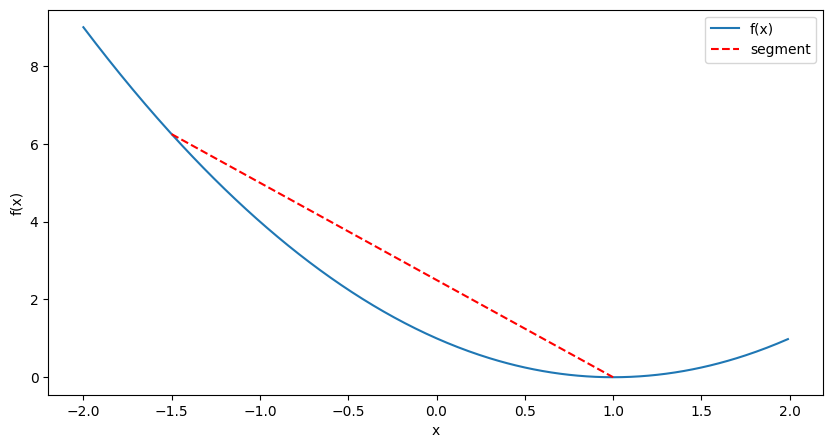

In [10]:
f = lambda x: (x - 1) ** 2
plt.figure(figsize=(10, 5))
plt.plot(x, f(x), label='f(x)')
plt.plot(segment, f(segment), 'r--', label='segment')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()

This property ensures that we do not get stuck when one or more minima exists. There are cases where there is no minima over a certain range

# Gradient Descent

In [11]:
def f(x):
    return x ** 2

def f_grad(x):
    return 2 * x

In [12]:
def gd(eta, f_grad):
    x = 10.0
    results = [x]
    for i in range(10):
        x -= eta * f_grad(x)
        results.append(float(x))
    print(f'epoch 10, x = {x:f}')
    return results

results = gd(0.2, f_grad)

epoch 10, x = 0.060466


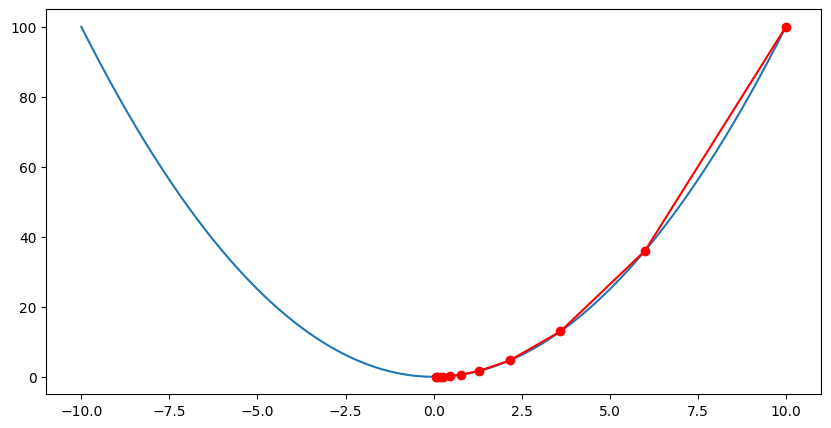

In [13]:
def show_trace(results, f):
    n = max(abs(min(results)), abs(max(results)))
    f_line = torch.arange(-n, n, 0.01)
    plt.figure(figsize=(10, 5))
    plt.plot(f_line, f(f_line), label='f(x)')
    plt.plot(results, f(torch.tensor(results)), 'ro-', label='trace')
    plt.show()

show_trace(results, f)

## Learning Rate

epoch 10, x = 3.486784


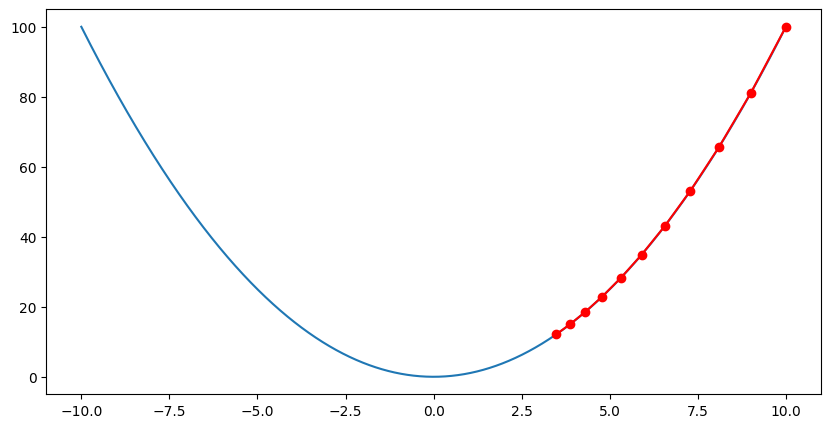

In [14]:
show_trace(gd(0.05, f_grad), f)

The above example shows an instance where the learning rate is too slow and thus does not reach the minima

epoch 10, x = 61.917364


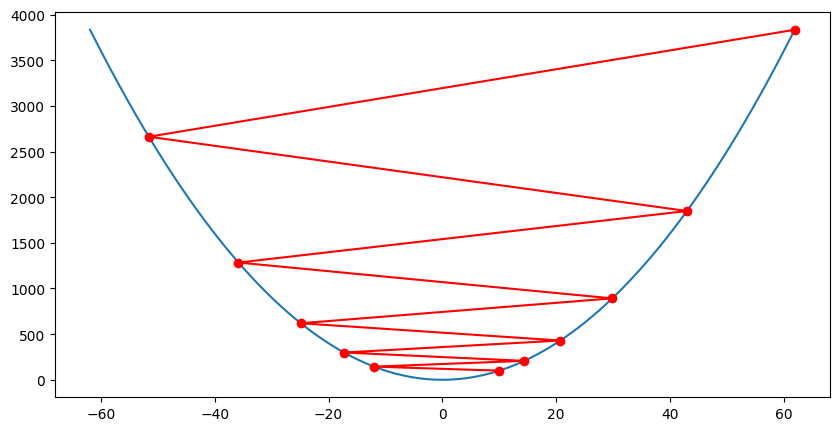

In [15]:
show_trace(gd(1.1, f_grad), f)

The above example shows an isntance where the learning rate is too fast and may or may not reach the minima

## Local Minima

epoch 10, x = -1.528166


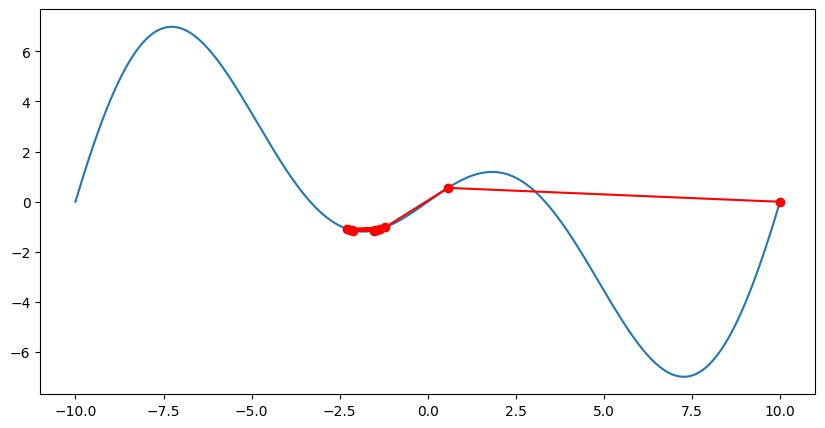

In [16]:
c = torch.tensor(0.15 * np.pi)

def f(x):  # Objective function
    return x * torch.cos(c * x)

def f_grad(x):  # Gradient of the objective function
    return torch.cos(c * x) - c * x * torch.sin(c * x)

show_trace(gd(2, f_grad), f)

Above is an example of a nonconvex function which has many local minima. The choice of learning rate and how well conditioned the problem is, we may end up with many solutions. A high learning rate can lead to a poor local minimum

# Multivariate Gradient Descent

In [17]:
def train_2d(trainer, steps=20, f_grad=None):  #@save
    """Optimize a 2D objective function with a customized trainer."""
    # `s1` and `s2` are internal state variables that will be used in Momentum, adagrad, RMSProp
    x1, x2, s1, s2 = -5, -2, 0, 0
    results = [(x1, x2)]
    for i in range(steps):
        if f_grad:
            x1, x2, s1, s2 = trainer(x1, x2, s1, s2, f_grad)
        else:
            x1, x2, s1, s2 = trainer(x1, x2, s1, s2)
        results.append((x1, x2))
    print(f'epoch {i + 1}, x1: {float(x1):f}, x2: {float(x2):f}')
    return results

def show_trace_2d(f, results):  #@save
    """Show the trace of 2D variables during optimization."""
    plt.figure(figsize=(10, 5))
    plt.title('2D Optimization Trace')
    plt.plot(*zip(*results), '-o', color='#ff7f0e')
    x1, x2 = torch.meshgrid(torch.arange(-5.5, 1.0, 0.1),
                          torch.arange(-3.0, 1.0, 0.1), indexing='ij')
    plt.contour(x1, x2, f(x1, x2), colors='#1f77b4')
    plt.xlabel('x1')
    plt.ylabel('x2')

epoch 20, x1: -0.057646, x2: -0.000073


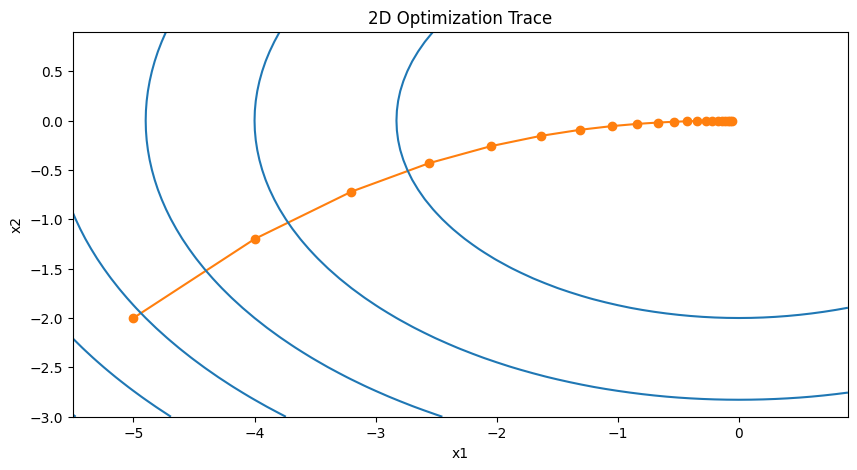

In [18]:
def f_2d(x1, x2):  # Objective function
    return x1 ** 2 + 2 * x2 ** 2

def f_2d_grad(x1, x2):  # Gradient of the objective function
    return (2 * x1, 4 * x2)

def gd_2d(x1, x2, s1, s2, f_grad):
    g1, g2 = f_grad(x1, x2)
    return (x1 - eta * g1, x2 - eta * g2, 0, 0)

eta = 0.1
show_trace_2d(f_2d, train_2d(gd_2d, f_grad=f_2d_grad))

# Adaptive Methods

## Newton's Method

Newton's method on a convex function

epoch 10, x: tensor(0.)


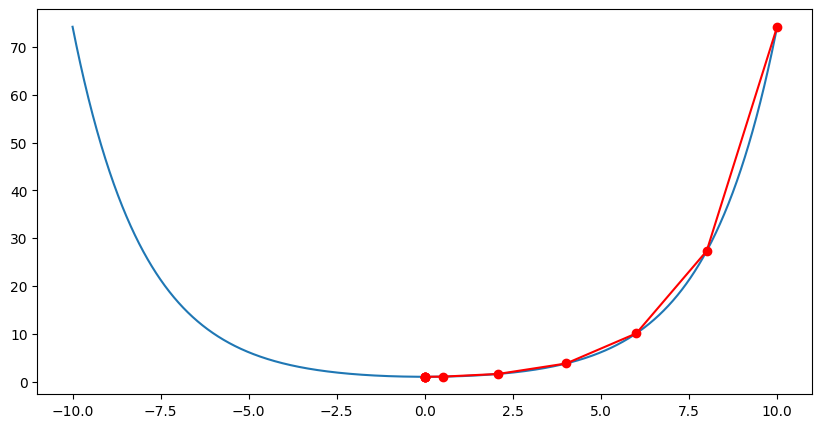

In [19]:
c = torch.tensor(0.5)

def f(x):  # Objective function
    return torch.cosh(c * x)

def f_grad(x):  # Gradient of the objective function
    return c * torch.sinh(c * x)

def f_hess(x):  # Hessian of the objective function
    return c**2 * torch.cosh(c * x)

def newton(eta=1):
    x = 10.0
    results = [x]
    for i in range(10):
        x -= eta * f_grad(x) / f_hess(x)
        results.append(float(x))
    print('epoch 10, x:', x)
    return results

show_trace(newton(), f)

Newton's method on a nonconvex function

epoch 10, x: tensor(26.8341)


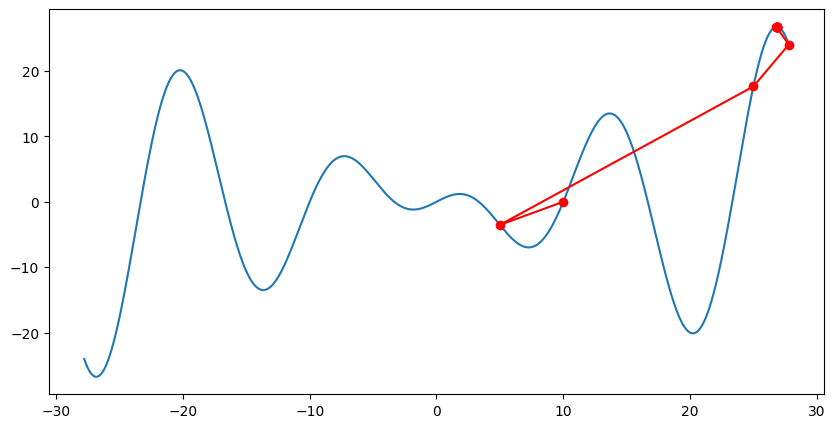

In [20]:
c = torch.tensor(0.15 * np.pi)

def f(x):  # Objective function
    return x * torch.cos(c * x)

def f_grad(x):  # Gradient of the objective function
    return torch.cos(c * x) - c * x * torch.sin(c * x)

def f_hess(x):  # Hessian of the objective function
    return - 2 * c * torch.sin(c * x) - x * c**2 * torch.cos(c * x)

show_trace(newton(), f)

epoch 10, x: tensor(7.2699)


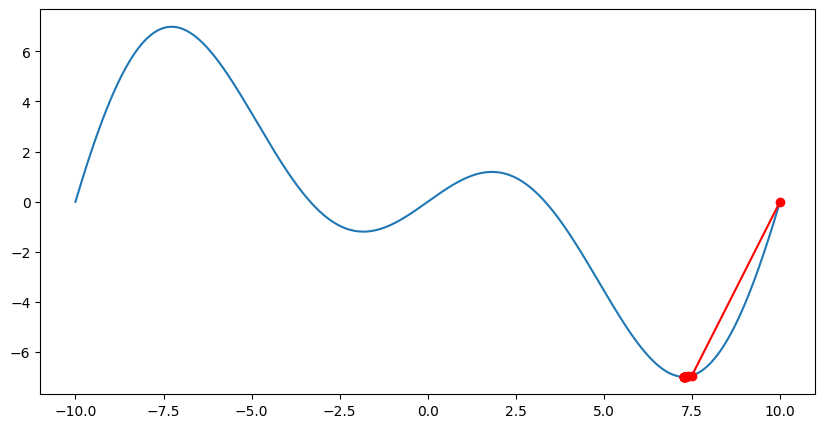

In [21]:
show_trace(newton(0.5), f)

# Stochastic Gradient Descent

Instead of incurring a cost of O(n) to calculate the gradient of the objective function, we can use the stochastic gradient as a good estimate of the gradient and bring down the computational cost to O(1) i.e. a significant improvement

epoch 50, x1: 0.204459, x2: -0.024745


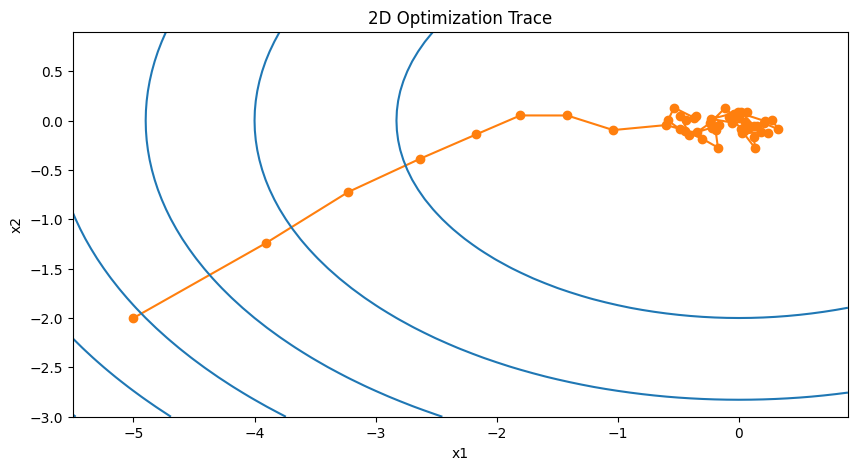

In [22]:
def f(x1, x2):  # Objective function
    return x1 ** 2 + 2 * x2 ** 2

def f_grad(x1, x2):  # Gradient of the objective function
    return 2 * x1, 4 * x2

def sgd(x1, x2, s1, s2, f_grad):
    g1, g2 = f_grad(x1, x2)
    # Simulate noisy gradient
    g1 += torch.normal(0.0, 1, (1,)).item()
    g2 += torch.normal(0.0, 1, (1,)).item()
    eta_t = eta * lr()
    return (x1 - eta_t * g1, x2 - eta_t * g2, 0, 0)

def constant_lr():
    return 1

eta = 0.1
lr = constant_lr  # Constant learning rate
show_trace_2d(f, train_2d(sgd, steps=50, f_grad=f_grad))

The trajectory of the variables in SGD is much more noisy than the ones we observed in Gradient Descent

## Dynamic Learning Rate

epoch 1000, x1: -0.937763, x2: -0.083452


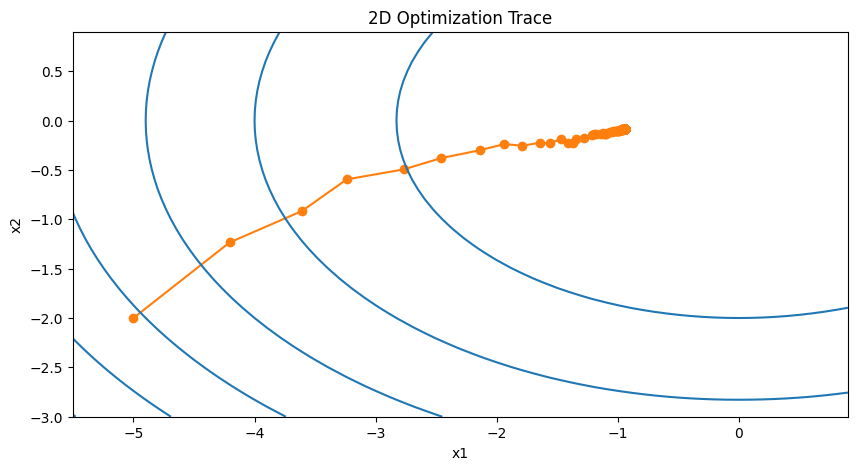

In [23]:
def exponential_lr():
    global t
    t += 1
    return math.exp(-0.1 * t)

t = 1
lr = exponential_lr
show_trace_2d(f, train_2d(sgd, steps=1000, f_grad=f_grad))

# Minibatch Stochastic Gradient Descent

In [24]:
A = torch.zeros(256, 256)
B = torch.randn(256, 256)
C = torch.randn(256, 256)


In [25]:
class Timer:
    """Recording multiple running times."""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()

In [26]:
timer = Timer()
timer.start()
for i in range(256):
    for j in range(256):
        A[i, j] = torch.dot(B[i, :], C[:, j])
timer.stop()

1.1840033531188965

In [27]:
# Compute A = BC one column at a time
timer.start()
for j in range(256):
    A[:, j] = torch.mv(B, C[:, j])
timer.stop()

0.010998249053955078

In [28]:
# Compute A = BC in one go
timer.start()
A = torch.mm(B, C)
timer.stop()

# Calculate Gigaflops with safety check for very small or zero values
gigaflops = []
for t in timer.times:
    if t > 1e-10:  # Threshold to avoid division by very small numbers
        gigaflops.append(0.03 / t)
    else:
        gigaflops.append(float('inf'))  # or use 0.0 if you prefer

print(f'performance in Gigaflops: element {gigaflops[0]:.3f}, '
      f'column {gigaflops[1]:.3f}, full {gigaflops[2]:.3f}')

performance in Gigaflops: element 0.025, column 2.728, full 4.936


Here we can view the difference between computing the dot product of two matrics element-wise (slowest), one column at a time and at one go (fastest)

## Minibatches

Using minibatches makes us more computationally efficient with an added benefit of reducing variance due to the reduction of standard deviation by a factor of $b^{-1/2}$

In [29]:
timer.start()
for j in range(0, 256, 64):
    A[:, j:j+64] = torch.mm(B, C[:, j:j+64])
timer.stop()
t = timer.times[-1]
if t > 1e-10:  # Threshold to avoid division by very small numbers
    gflops = 0.03 / t
else:
    gflops = float('inf')  # or use a large number like 1e6
print(f'performance in Gigaflops: block {gflops:.3f}')

performance in Gigaflops: block 30.024


## Reading the dataset

In [30]:

def linreg(X, w, b):
    """Linear regression model."""
    return torch.matmul(X, w) + b

def squared_loss(y_hat, y):
    """Squared loss function."""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

def evaluate_loss(net, data_iter, loss):
    """Evaluate the loss of a model on the given dataset."""
    metric = 0.0
    num_batches = 0
    with torch.no_grad():
        for X, y in data_iter:
            l = loss(net(X), y)
            metric += l.sum()
            num_batches += y.numel()
    return metric / num_batches

class Animator:
    """Simple animator that stores data and shows final plot."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(10, 6)):
        self.xlabel = xlabel or 'x'
        self.ylabel = ylabel or 'y' 
        self.xlim = xlim
        self.ylim = ylim
        self.xscale = xscale
        self.yscale = yscale
        self.fmts = fmts
        self.figsize = figsize
        self.X, self.Y = [], []
        self.legend = legend or []

    def add(self, x, y):
        """Add data points to the plot."""
        # Handle 0-d tensors by converting to float first
        if hasattr(y, 'item') and hasattr(y, 'dim') and y.dim() == 0:
            y = float(y.item())
        if hasattr(x, 'item') and hasattr(x, 'dim') and x.dim() == 0:
            x = float(x.item())
        
        # Convert to list if not already
        if not hasattr(y, "__len__"):
            y = [y]
        if not hasattr(x, "__len__"):
            x = [x] * len(y)
        
        # Initialize data structure if needed
        if not self.X:
            self.X = [[] for _ in range(len(y))]
        if not self.Y:
            self.Y = [[] for _ in range(len(y))]
            
        # Add new data points
        for i, (x_val, y_val) in enumerate(zip(x, y)):
            if x_val is not None and y_val is not None:
                self.X[i].append(float(x_val))
                self.Y[i].append(float(y_val))
        
        # Print progress every few points
        if len(self.X[0]) % 5 == 0:
            print(f"  Step {len(self.X[0])}: Loss = {float(y[0]):.4f}")
    
    def show(self):
        """Display the final plot."""
        plt.figure(figsize=self.figsize)
        
        for i, (x_data, y_data) in enumerate(zip(self.X, self.Y)):
            if len(x_data) > 0:
                fmt = self.fmts[i % len(self.fmts)]
                label = self.legend[i] if i < len(self.legend) else f'Series {i}'
                plt.plot(x_data, y_data, fmt, label=label, linewidth=2)
        
        plt.xlabel(self.xlabel)
        plt.ylabel(self.ylabel)
        if self.xlim:
            plt.xlim(self.xlim)
        if self.ylim:
            plt.ylim(self.ylim)
        plt.xscale(self.xscale)
        plt.yscale(self.yscale)
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.title(f'{self.ylabel} vs {self.xlabel}')
        plt.tight_layout()
        plt.show()


In [31]:
airfoil_path = 'airfoil+self+noise/airfoil_self_noise.dat'
def get_data_ch11(batch_size=10, n=1500):
    data = np.genfromtxt(airfoil_path, dtype=np.float32, delimiter='\t')
    data = torch.from_numpy((data - data.mean(axis=0)) / data.std(axis=0))
    features, labels = data[:n, :-1], data[:n, -1]
    dataset = torch.utils.data.TensorDataset(features, labels)
    data_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
    return data_iter, data.shape[1]-1

## Implementation from scratch

In [32]:
def sgd(params, states, hyperparams):
    for p in params:
        p.data.sub_(hyperparams['lr'] * p.grad)
        p.grad.data.zero_()

In [33]:
def train_ch11(trainer_fn, states, hyperparams, data_iter,
               feature_dim, num_epochs=2):
    # Initialization
    w = torch.normal(mean=0.0, std=0.01, size=(feature_dim, 1),
                     requires_grad=True)
    b = torch.zeros((1), requires_grad=True)
    net, loss = lambda X: linreg(X, w, b), squared_loss
    
    # Train
    animator = Animator(xlabel='Epoch', ylabel='Loss', legend=['Training Loss'])
    n, timer = 0, Timer()
    timer.start()
    
    print(f"Training for {num_epochs} epochs...")
    for epoch in range(num_epochs):
        for X, y in data_iter:
            l = loss(net(X), y).mean()
            l.backward()
            trainer_fn([w, b], states, hyperparams)
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                current_loss = evaluate_loss(net, data_iter, loss)
                #animator.add(n/X.shape[0]/len(data_iter), current_loss)
                animator.add(float(n/X.shape[0]/len(data_iter)), current_loss)
                timer.start()
    
    timer.stop()
    final_loss = animator.Y[0][-1] if animator.Y[0] else 0
    print(f'Final loss: {final_loss:.3f}, {timer.sum()/num_epochs:.3f} sec/epoch')
    
    # Show the training plot
    animator.show()
    
    return timer.cumsum(), animator.Y[0]

Training for 10 epochs...
  Step 5: Loss = 0.2515
Final loss: 0.251, 0.017 sec/epoch


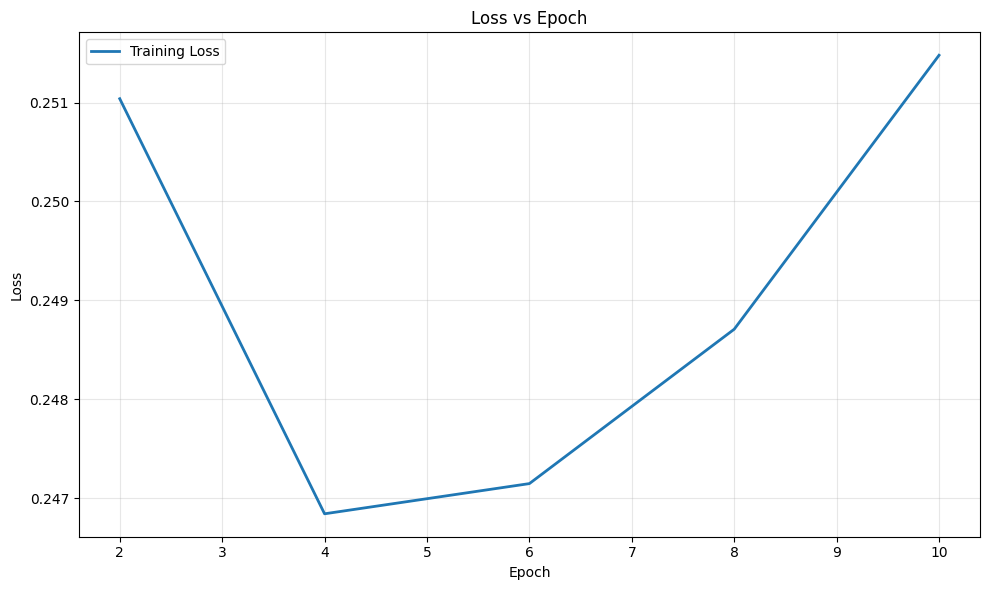

In [34]:
def train_sgd(lr, batch_size, num_epochs=2):
    data_iter, feature_dim = get_data_ch11(batch_size)
    return train_ch11(
        sgd, None, {'lr': lr}, data_iter, feature_dim, num_epochs)

gd_res = train_sgd(1, 1500, 10)

1. GRADIENT DESCENT (Full Batch)
Training for 10 epochs...
  Step 5: Loss = 0.2451
Final loss: 0.245, 0.019 sec/epoch


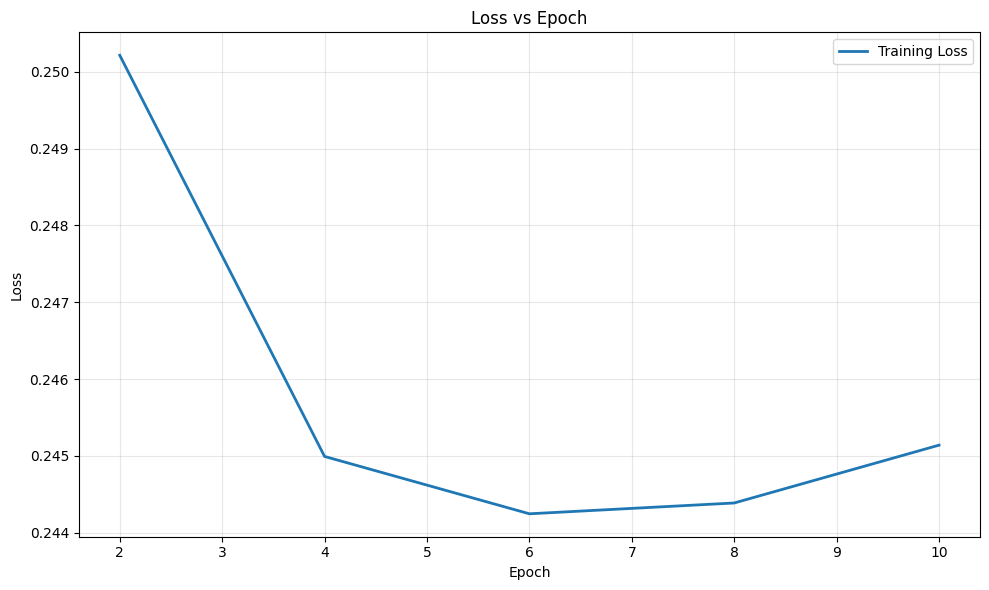

In [35]:
# Clear any existing plots
plt.close('all')

# 1. Gradient Descent (batch_size = full dataset = 1500)
print("="*50)
print("1. GRADIENT DESCENT (Full Batch)")
print("="*50)
gd_res = train_sgd(1, 1500, 10)  # lr=1, batch_size=1500 (full dataset)

2. STOCHASTIC GRADIENT DESCENT (SGD)
Training for 10 epochs...
  Step 5: Loss = 0.2446
  Step 10: Loss = 0.2433
  Step 15: Loss = 0.2429
  Step 20: Loss = 0.2469
  Step 25: Loss = 0.2428
  Step 30: Loss = 0.2419
  Step 35: Loss = 0.2432
  Step 40: Loss = 0.2456
  Step 45: Loss = 0.2451
  Step 50: Loss = 0.2485
  Step 55: Loss = 0.2481
  Step 60: Loss = 0.2465
  Step 65: Loss = 0.2429
  Step 70: Loss = 0.2433
  Step 75: Loss = 0.2428
Final loss: 0.243, 0.431 sec/epoch


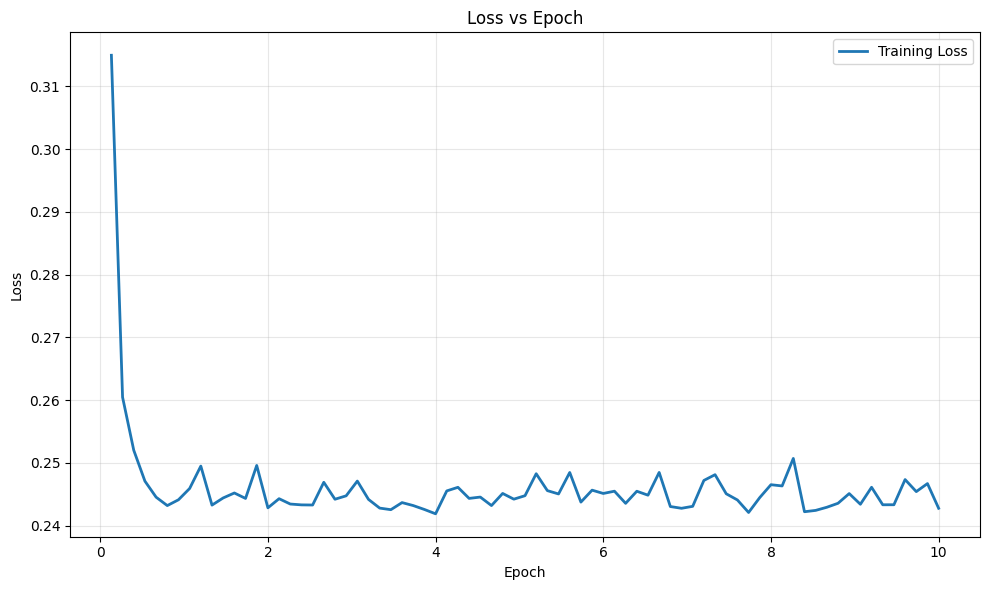

In [36]:
# 2. Stochastic Gradient Descent (batch_size = 1)
print("="*50)
print("2. STOCHASTIC GRADIENT DESCENT (SGD)")
print("="*50)
sgd_res = train_sgd(0.005, 1, 10)  # lr=0.005, batch_size=1


3. MINIBATCH SGD (batch_size=10)
Training for 10 epochs...
  Step 5: Loss = 0.2455
  Step 10: Loss = 0.2434
  Step 15: Loss = 0.2430
  Step 20: Loss = 0.2460
  Step 25: Loss = 0.2494
  Step 30: Loss = 0.2429
  Step 35: Loss = 0.2425
  Step 40: Loss = 0.2425
  Step 45: Loss = 0.2426
  Step 50: Loss = 0.2451
  Step 55: Loss = 0.2435
  Step 60: Loss = 0.2447
  Step 65: Loss = 0.2430
  Step 70: Loss = 0.2440
  Step 75: Loss = 0.2461
Final loss: 0.246, 0.053 sec/epoch


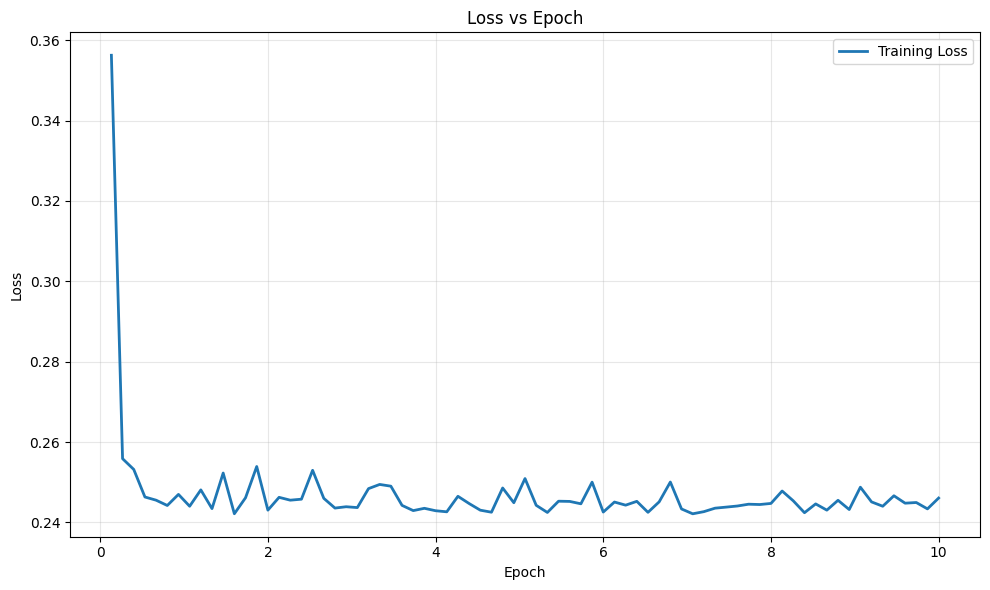

In [37]:
# 3. Minibatch SGD with batch_size = 10
print("="*50)
print("3. MINIBATCH SGD (batch_size=10)")
print("="*50)
minibatch_10_res = train_sgd(0.05, 10, 10)  # lr=0.05, batch_size=10


4. MINIBATCH SGD (batch_size=100)
Training for 10 epochs...
  Step 5: Loss = 0.3071
  Step 10: Loss = 0.2595
  Step 15: Loss = 0.2495
  Step 20: Loss = 0.2447
  Step 25: Loss = 0.2453
  Step 30: Loss = 0.2439
  Step 35: Loss = 0.2425
  Step 40: Loss = 0.2426
  Step 45: Loss = 0.2423
  Step 50: Loss = 0.2424
  Step 55: Loss = 0.2420
  Step 60: Loss = 0.2420
  Step 65: Loss = 0.2420
  Step 70: Loss = 0.2435
  Step 75: Loss = 0.2424
Final loss: 0.242, 0.015 sec/epoch


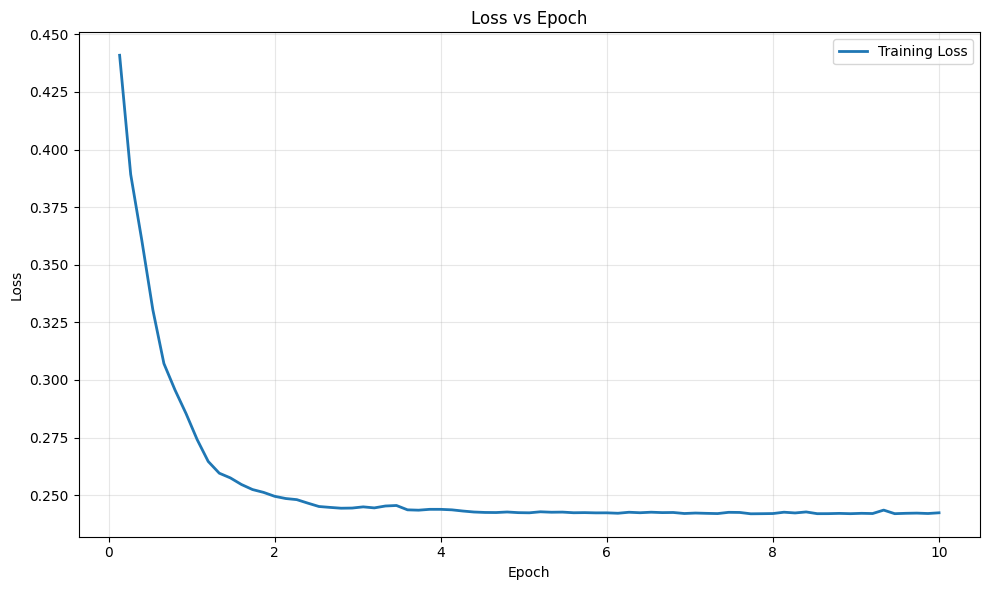

In [38]:
# 4. Minibatch SGD with batch_size = 100
print("="*50)
print("4. MINIBATCH SGD (batch_size=100)")
print("="*50)
minibatch_100_res = train_sgd(0.1, 100, 10)  # lr=0.1, batch_size=100


COMPARISON OF ALL OPTIMIZATION METHODS


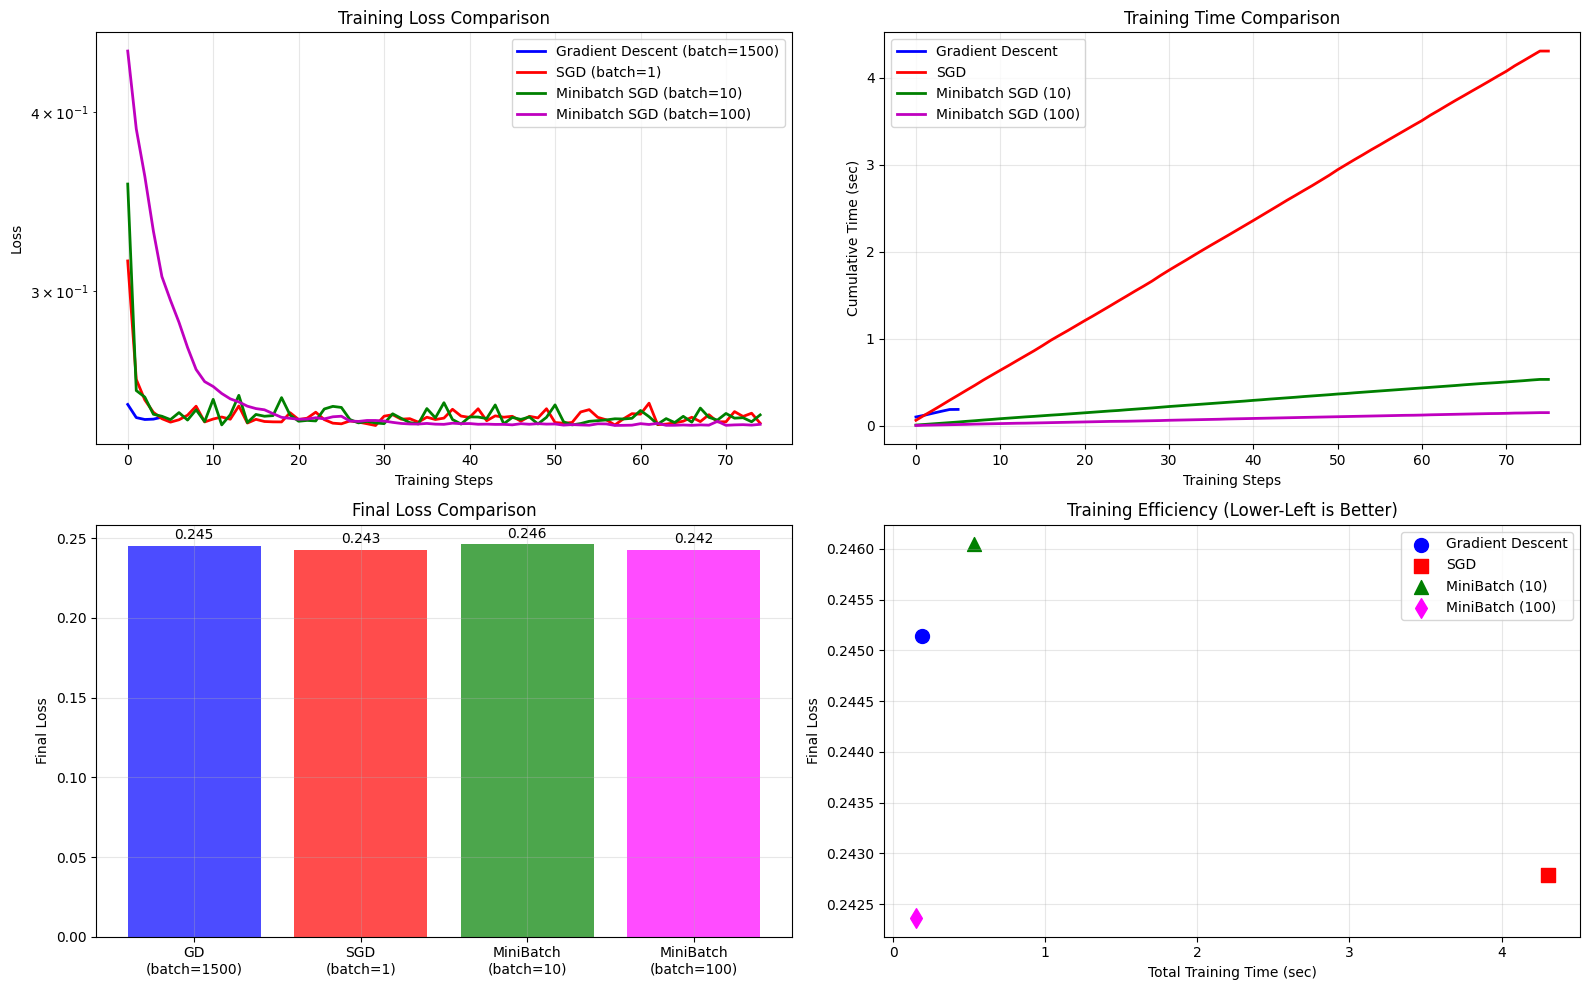


SUMMARY STATISTICS:
----------------------------------------
Gradient Descent:      Final Loss = 0.2451, Time = 0.187s
SGD (batch=1):         Final Loss = 0.2428, Time = 4.308s
MiniBatch SGD (b=10):  Final Loss = 0.2461, Time = 0.532s
MiniBatch SGD (b=100): Final Loss = 0.2424, Time = 0.150s


In [39]:
# Comprehensive comparison of all optimization methods
print("="*60)
print("COMPARISON OF ALL OPTIMIZATION METHODS")
print("="*60)

plt.figure(figsize=(16, 10))

# Plot 1: Loss Comparison
plt.subplot(2, 2, 1)
if len(gd_res[1]) > 0:
    plt.plot(gd_res[1], 'b-', label='Gradient Descent (batch=1500)', linewidth=2)
if len(sgd_res[1]) > 0:
    plt.plot(sgd_res[1], 'r-', label='SGD (batch=1)', linewidth=2)
if len(minibatch_10_res[1]) > 0:
    plt.plot(minibatch_10_res[1], 'g-', label='Minibatch SGD (batch=10)', linewidth=2)
if len(minibatch_100_res[1]) > 0:
    plt.plot(minibatch_100_res[1], 'm-', label='Minibatch SGD (batch=100)', linewidth=2)

plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')  # Log scale to better see convergence

# Plot 2: Training Time Comparison
plt.subplot(2, 2, 2)
if len(gd_res[0]) > 0:
    plt.plot(gd_res[0], 'b-', label='Gradient Descent', linewidth=2)
if len(sgd_res[0]) > 0:
    plt.plot(sgd_res[0], 'r-', label='SGD', linewidth=2)
if len(minibatch_10_res[0]) > 0:
    plt.plot(minibatch_10_res[0], 'g-', label='Minibatch SGD (10)', linewidth=2)
if len(minibatch_100_res[0]) > 0:
    plt.plot(minibatch_100_res[0], 'm-', label='Minibatch SGD (100)', linewidth=2)

plt.xlabel('Training Steps')
plt.ylabel('Cumulative Time (sec)')
plt.title('Training Time Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Final Loss Comparison (Bar Chart)
plt.subplot(2, 2, 3)
methods = ['GD\n(batch=1500)', 'SGD\n(batch=1)', 'MiniBatch\n(batch=10)', 'MiniBatch\n(batch=100)']
final_losses = [
    gd_res[1][-1] if len(gd_res[1]) > 0 else 0,
    sgd_res[1][-1] if len(sgd_res[1]) > 0 else 0,
    minibatch_10_res[1][-1] if len(minibatch_10_res[1]) > 0 else 0,
    minibatch_100_res[1][-1] if len(minibatch_100_res[1]) > 0 else 0
]
colors = ['blue', 'red', 'green', 'magenta']
bars = plt.bar(methods, final_losses, color=colors, alpha=0.7)
plt.ylabel('Final Loss')
plt.title('Final Loss Comparison')
plt.grid(True, alpha=0.3)
# Add value labels on bars
for bar, loss in zip(bars, final_losses):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(final_losses)*0.01, 
             f'{loss:.3f}', ha='center', va='bottom')

# Plot 4: Training Efficiency (Loss vs Time)
plt.subplot(2, 2, 4)
if len(gd_res[0]) > 0 and len(gd_res[1]) > 0:
    plt.scatter(gd_res[0][-1], gd_res[1][-1], s=100, c='blue', label='Gradient Descent', marker='o')
if len(sgd_res[0]) > 0 and len(sgd_res[1]) > 0:
    plt.scatter(sgd_res[0][-1], sgd_res[1][-1], s=100, c='red', label='SGD', marker='s')
if len(minibatch_10_res[0]) > 0 and len(minibatch_10_res[1]) > 0:
    plt.scatter(minibatch_10_res[0][-1], minibatch_10_res[1][-1], s=100, c='green', label='MiniBatch (10)', marker='^')
if len(minibatch_100_res[0]) > 0 and len(minibatch_100_res[1]) > 0:
    plt.scatter(minibatch_100_res[0][-1], minibatch_100_res[1][-1], s=100, c='magenta', label='MiniBatch (100)', marker='d')

plt.xlabel('Total Training Time (sec)')
plt.ylabel('Final Loss')
plt.title('Training Efficiency (Lower-Left is Better)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSUMMARY STATISTICS:")
print("-" * 40)
print(f"Gradient Descent:      Final Loss = {gd_res[1][-1]:.4f}, Time = {gd_res[0][-1]:.3f}s")
print(f"SGD (batch=1):         Final Loss = {sgd_res[1][-1]:.4f}, Time = {sgd_res[0][-1]:.3f}s")
print(f"MiniBatch SGD (b=10):  Final Loss = {minibatch_10_res[1][-1]:.4f}, Time = {minibatch_10_res[0][-1]:.3f}s")
print(f"MiniBatch SGD (b=100): Final Loss = {minibatch_100_res[1][-1]:.4f}, Time = {minibatch_100_res[0][-1]:.3f}s")


## Concise Implementation

In [40]:
def train_concise_ch11(trainer_fn, hyperparams, data_iter, num_epochs=4):
    net = torch.nn.Sequential(torch.nn.Linear(5, 1))
    def init_weights(m):
        if type(m) == torch.nn.Linear:
            torch.nn.init.normal_(m.weight, std=0.01)
    net.apply(init_weights)

    optimizer = trainer_fn(net.parameters(), **hyperparams)

    # Note: `MSELoss` computes squared error without the 1/2 factor
    loss = torch.nn.MSELoss(reduction='none')
    animator = Animator(xlabel='epoch', ylabel='loss')
    n, timer = 0, Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            optimizer.zero_grad()
            out = net(X)
            y = y.reshape(out.shape)
            l = loss(out, y)
            l.mean().backward()
            optimizer.step()
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                # `MSELoss` computes squared error without the 1/2 factor
                animator.add(n/X.shape[0]/len(data_iter),
                             (evaluate_loss(net, data_iter, loss) / 2,))
                timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.avg():.3f} sec/epoch')
    animator.show()

def train_concise_ch11(trainer_fn, hyperparams, data_iter, num_epochs=4):
    # Get feature dimension from data
    for X, y in data_iter:
        feature_dim = X.shape[1]
        break
    
    # Initialization with correct feature dimension
    net = torch.nn.Sequential(torch.nn.Linear(feature_dim, 1))
    def init_weights(module):
        if type(module) == torch.nn.Linear:
            torch.nn.init.normal_(module.weight, std=0.001)  # Smaller initialization
    net.apply(init_weights)

    # Create optimizer with proper momentum handling
    optimizer = trainer_fn(net.parameters(), **hyperparams)
    loss = torch.nn.MSELoss()
    animator = Animator(xlabel='epoch', ylabel='loss')
    n, timer = 0, Timer()
    print(f"Training for {num_epochs} epochs...")
    
    for epoch in range(num_epochs):
        for X, y in data_iter:
            optimizer.zero_grad()
            out = net(X)
            y = y.reshape(out.shape)
            l = loss(out, y)
            l.backward()
            optimizer.step()
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                current_loss = evaluate_loss(net, data_iter, loss)
                animator.add(float(n/X.shape[0]/len(data_iter)), current_loss)
                timer.start()
    
    final_loss = animator.Y[0][-1] if animator.Y[0] else 0
    print(f'Final loss: {final_loss:.3f}, {timer.sum()/num_epochs:.3f} sec/epoch')
    
    # Show the training plot
    animator.show()

def train_concise_ch11(trainer_fn, hyperparams, data_iter, num_epochs=4):
    # Get feature dimension from data
    for X, y in data_iter:
        feature_dim = X.shape[1]
        break

    net = torch.nn.Sequential(torch.nn.Linear(feature_dim, 1))
    def init_weights(m):
        if type(m) == torch.nn.Linear:
            torch.nn.init.normal_(m.weight, std=0.01)
    net.apply(init_weights)

    optimizer = trainer_fn(net.parameters(), **hyperparams)
    loss = torch.nn.MSELoss(reduction='none')
    epoch_losses = []
    timer = Timer()
    timer.start()
    for epoch in range(num_epochs):
        batch_losses = []
        for X, y in data_iter:
            optimizer.zero_grad()
            out = net(X)
            y = y.reshape(out.shape)
            l = loss(out, y)
            l.mean().backward()
            optimizer.step()
            batch_losses.append(l.mean().item())
        # Average loss for the epoch
        epoch_loss = np.mean(batch_losses)
        epoch_losses.append(epoch_loss)
    timer.stop()
    print(f'Final loss: {epoch_losses[-1]:.3f}, {timer.avg():.3f} sec/epoch')
    # Plot loss vs epoch
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o', label='Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss vs Epoch')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

Final loss: 0.488, 0.258 sec/epoch


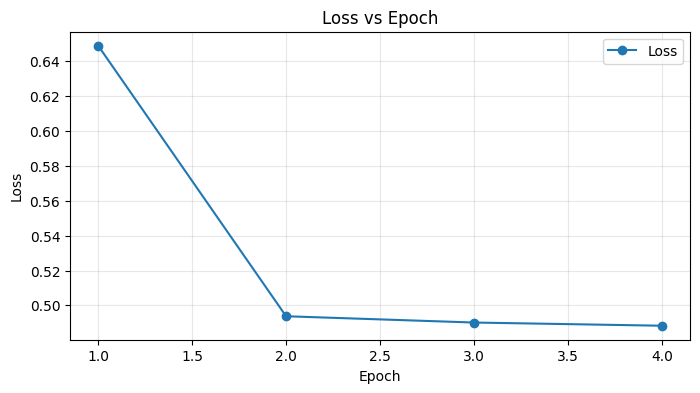

In [41]:
data_iter, _ = get_data_ch11(10)
trainer = torch.optim.SGD
train_concise_ch11(trainer, {'lr': 0.01}, data_iter)

# Momentum

## An Ill-conditioned Problem

We chose a function $f(\vec{x}) = 0.1 x_1^2 + 2 x_2^2$ where $f$ has its minimum at $(0,0)$. The function is very flat in the direction of $x_1$

epoch 20, x1: -0.943467, x2: -0.000073


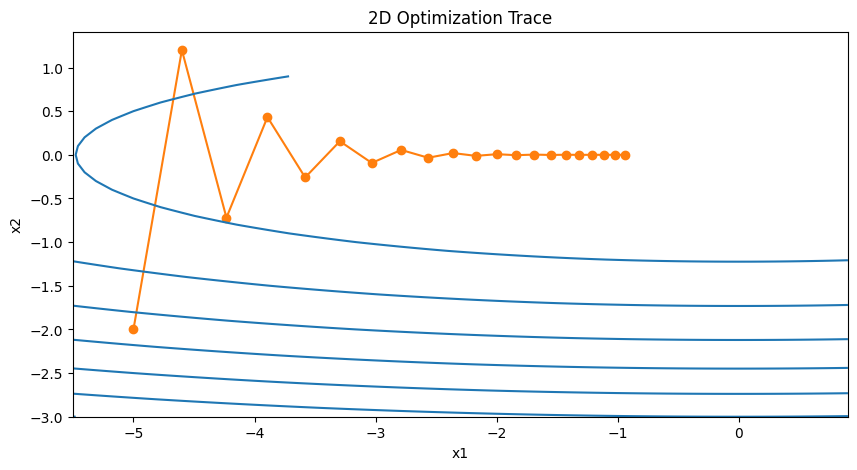

In [42]:

eta = 0.4
def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2
def gd_2d(x1, x2, s1, s2):
    return (x1 - eta * 0.2 * x1, x2 - eta * 4 * x2, 0, 0)

show_trace_2d(f_2d, train_2d(gd_2d))

By design, the gradient in the $x_2$ direction is much higher and changes more rapidly than in the $x_1$ direction. Making a change in the learning rate to increase it and therefore progress in the direction of $x_1$

epoch 20, x1: -0.387814, x2: -1673.365109


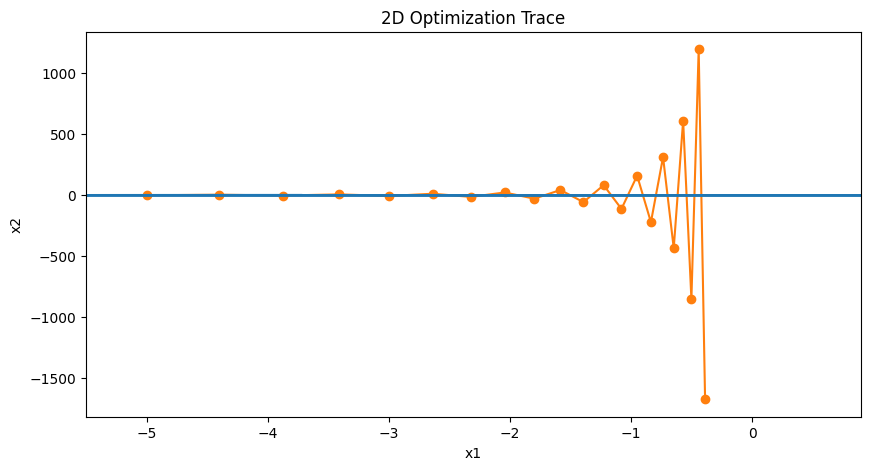

In [43]:
eta = 0.6
show_trace_2d(f_2d, train_2d(gd_2d))

## The Momentum Method

epoch 20, x1: 0.007188, x2: 0.002553


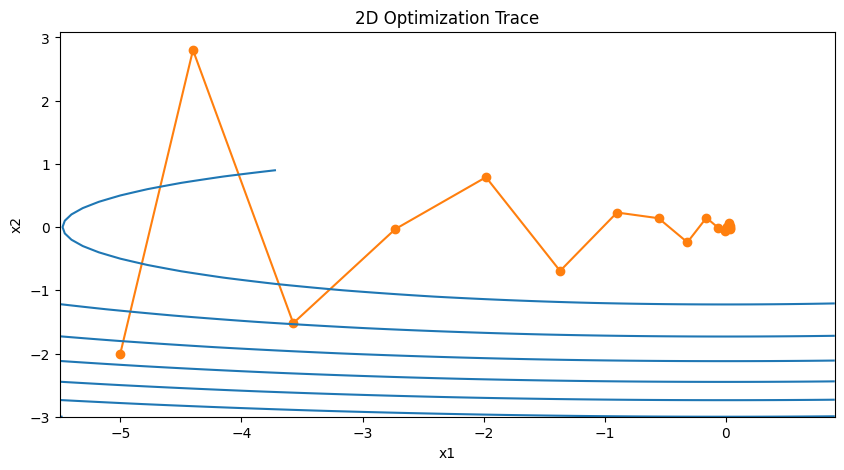

In [44]:
def momentum_2d(x1, x2, v1, v2):
    v1 = beta * v1 + 0.2 * x1
    v2 = beta * v2 + 4 * x2
    return x1 - eta * v1, x2 - eta * v2, v1, v2

eta, beta = 0.6, 0.5
show_trace_2d(f_2d, train_2d(momentum_2d))

epoch 20, x1: -0.126340, x2: -0.186632


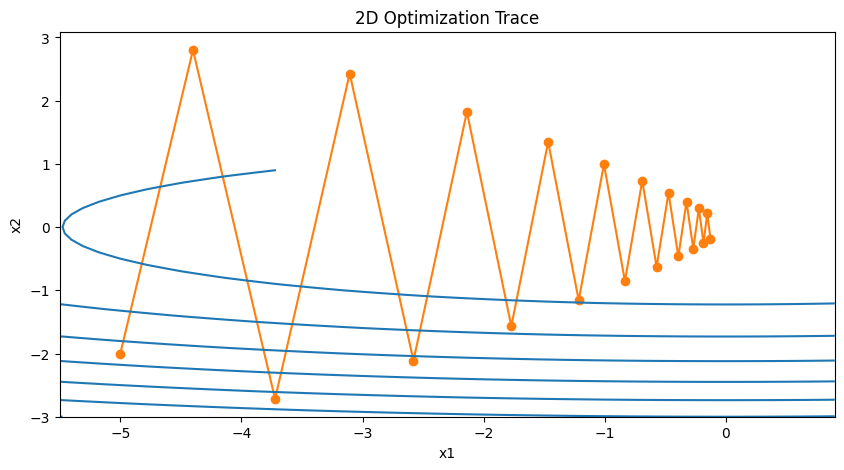

In [45]:
eta, beta = 0.6, 0.25
show_trace_2d(f_2d, train_2d(momentum_2d))

## Effective Sample Weight

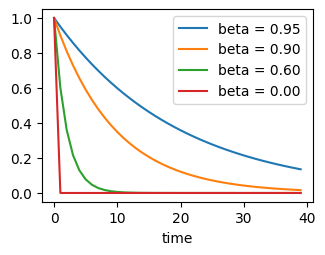

In [46]:
plt.figure(figsize=(3.5, 2.5))
betas = [0.95, 0.9, 0.6, 0]
for beta in betas:
    x = torch.arange(40).detach().numpy()
    plt.plot(x, beta ** x, label=f'beta = {beta:.2f}')
plt.xlabel('time')
plt.legend()
plt.show()

## Implementation From Scratch

In [47]:
def init_momentum_states(feature_dim):
    v_w = torch.zeros((feature_dim, 1))
    v_b = torch.zeros(1)
    return (v_w, v_b)

def sgd_momentum(params, states, hyperparams):
    for p, v in zip(params, states):
        with torch.no_grad():
            v[:] = hyperparams['momentum'] * v + p.grad
            p[:] -= hyperparams['lr'] * v
        p.grad.data.zero_()

def train_momentum(lr, momentum, num_epochs=2):
    data_iter, feature_dim = get_data_ch11(batch_size=10)  # Get actual feature_dim
    train_ch11(sgd_momentum, init_momentum_states(feature_dim),
                      {'lr': lr, 'momentum': momentum}, data_iter,
                      feature_dim, num_epochs)

Training for 2 epochs...
  Step 5: Loss = 0.2526
  Step 10: Loss = 0.2436
  Step 15: Loss = 0.2444
Final loss: 0.244, 0.065 sec/epoch


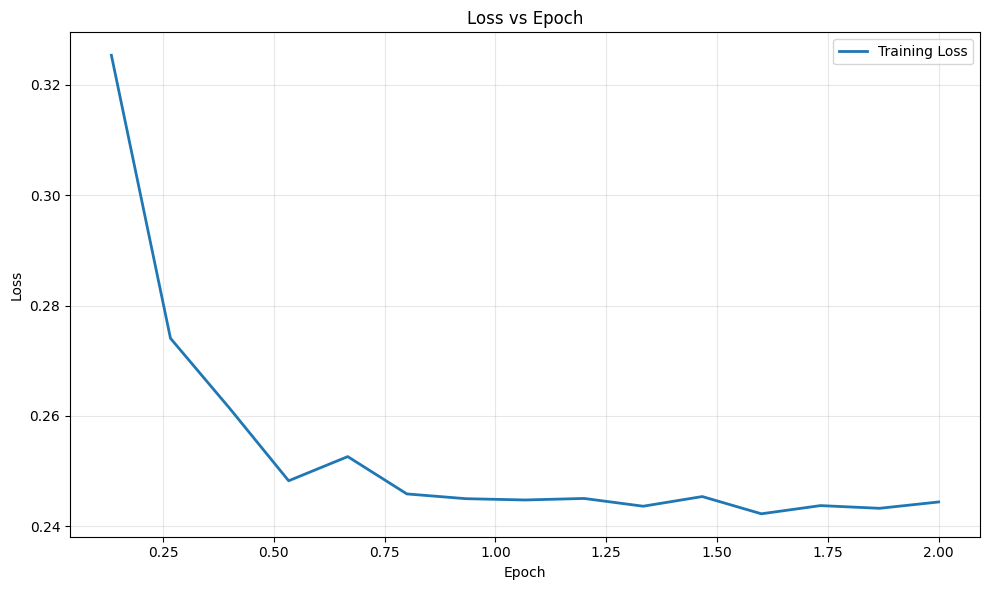

In [48]:
data_iter, feature_dim = get_data_ch11(batch_size=10)
train_momentum(0.02, 0.5)

Training for 2 epochs...
  Step 5: Loss = 0.2448
  Step 10: Loss = 0.2541
  Step 15: Loss = 0.2493
Final loss: 0.249, 0.065 sec/epoch


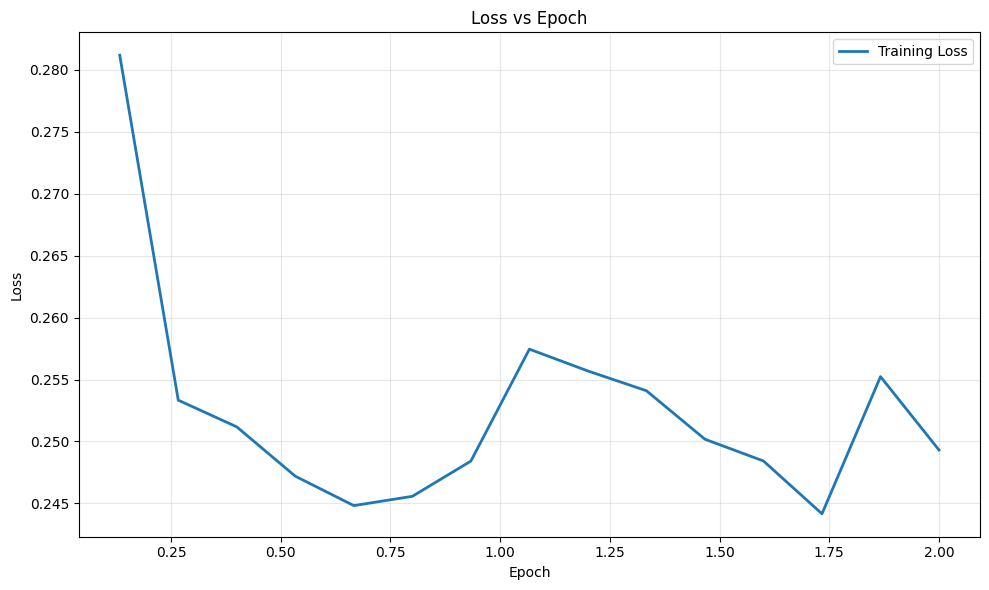

In [49]:
train_momentum(0.01, 0.9)

Training for 2 epochs...
  Step 5: Loss = 0.2459
  Step 10: Loss = 0.2456
  Step 15: Loss = 0.2456
Final loss: 0.246, 0.062 sec/epoch


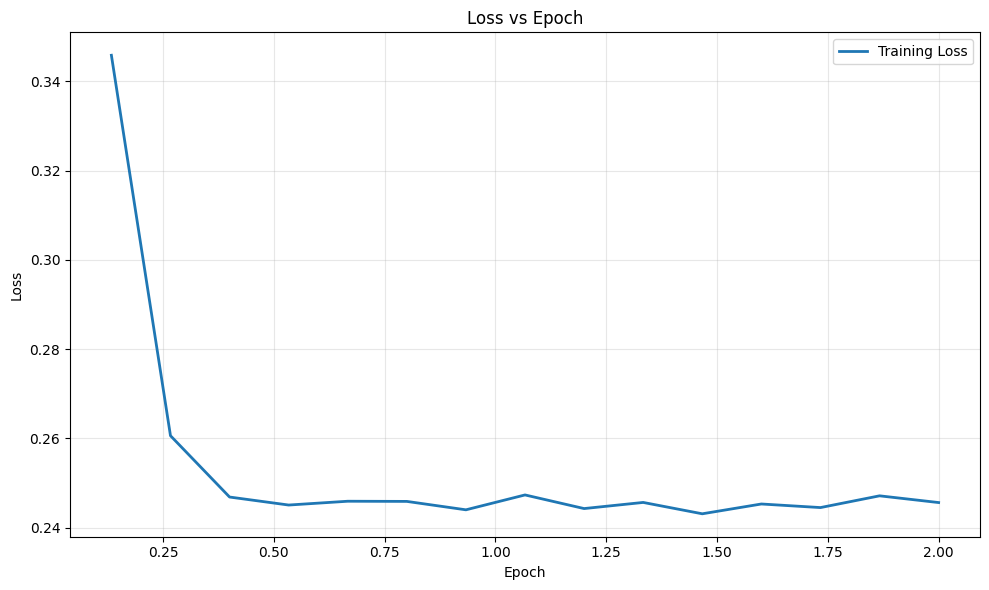

In [50]:
train_momentum(0.005, 0.9)

## Concise Implementation

Final loss: 0.487, 0.274 sec/epoch


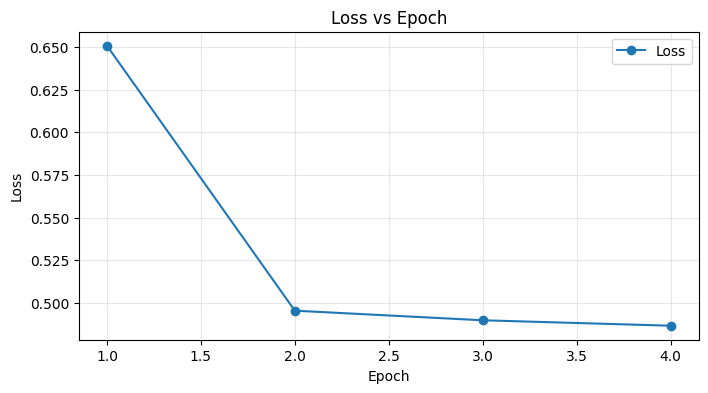

In [51]:
# Use momentum SGD with proper parameters
trainer = torch.optim.SGD
data_iter, _ = get_data_ch11(10)

train_concise_ch11(trainer, {'lr': 0.001, 'momentum': 0.9}, data_iter) 

# Adagrad

Adagrad aims to adjust the learning rate based on a proxy of the scale of the Hessian. It incures a computational cost of $O(t^{-1/2})$. This is sufficient for a convex problem but we might want to slow down further for a nonconvex problem. For now, we see how the algorithm behaves on a quadratic convex problem $f(\vec{x}) = 0.1x_1^2 + 2x_2^2$

epoch 20, x1: -2.382563, x2: -0.158591


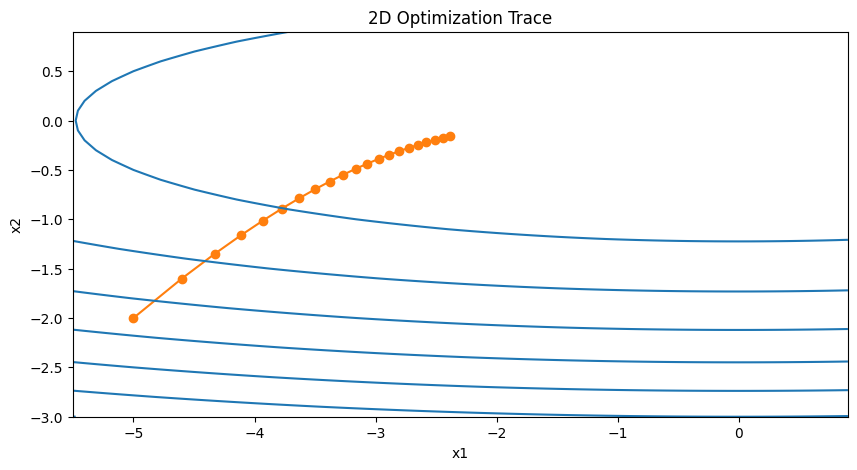

In [52]:
def adagrad_2d(x1, x2, s1, s2):
    eps = 1e-6
    g1, g2 = 0.2 * x1, 4 * x2
    s1 += g1 ** 2
    s2 += g2 ** 2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

eta = 0.4
show_trace_2d(f_2d, train_2d(adagrad_2d))

epoch 20, x1: -0.002295, x2: -0.000000


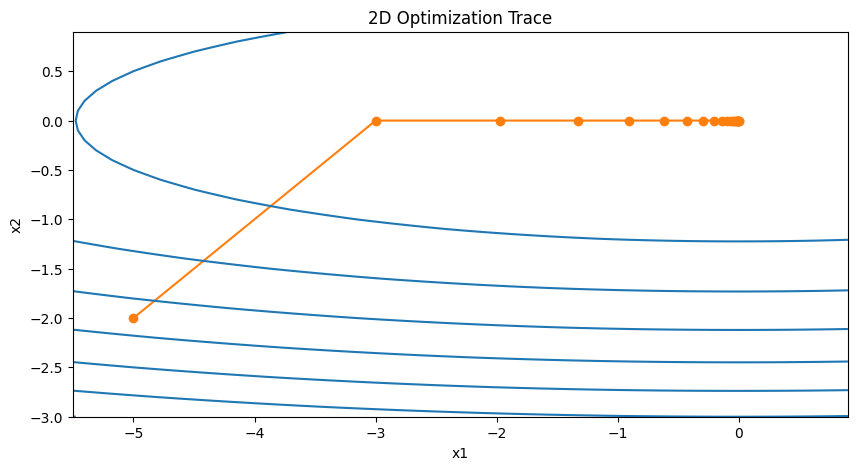

In [53]:
eta = 2
show_trace_2d(f_2d, train_2d(adagrad_2d))

## Implementation From Scratch

Training for 10 epochs...
  Step 5: Loss = 0.2452
  Step 10: Loss = 0.2431
  Step 15: Loss = 0.2424
  Step 20: Loss = 0.2429
  Step 25: Loss = 0.2420
  Step 30: Loss = 0.2421
  Step 35: Loss = 0.2421
  Step 40: Loss = 0.2430
  Step 45: Loss = 0.2420
  Step 50: Loss = 0.2436
  Step 55: Loss = 0.2426
  Step 60: Loss = 0.2417
  Step 65: Loss = 0.2428
  Step 70: Loss = 0.2423
  Step 75: Loss = 0.2418
Final loss: 0.242, 0.065 sec/epoch


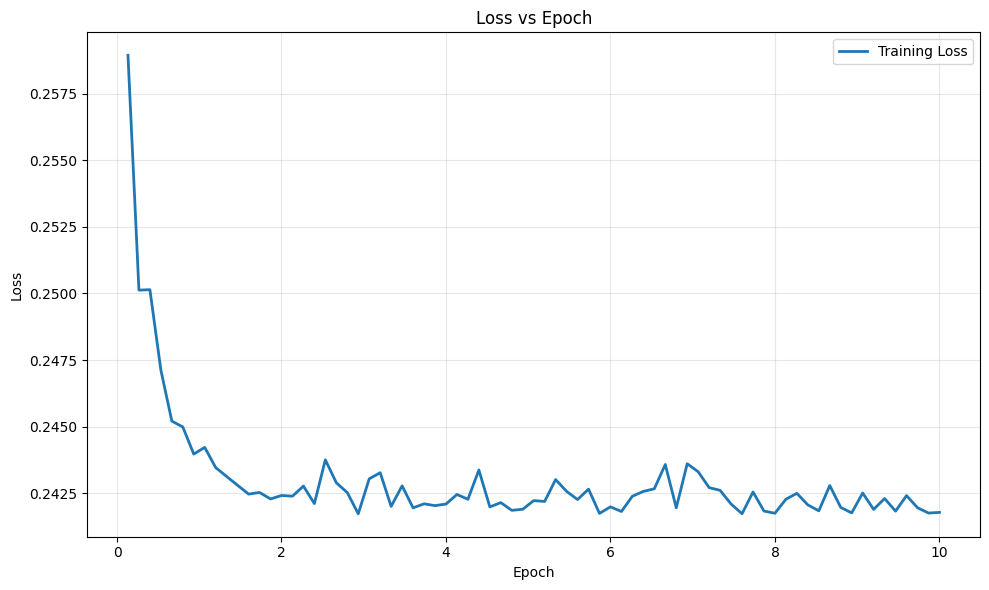

([0.009999513626098633,
  0.019997119903564453,
  0.028997182846069336,
  0.03699636459350586,
  0.04599785804748535,
  0.05499911308288574,
  0.06399965286254883,
  0.07199859619140625,
  0.07999753952026367,
  0.08799505233764648,
  0.09699463844299316,
  0.10499358177185059,
  0.11299586296081543,
  0.12099194526672363,
  0.12899327278137207,
  0.13799571990966797,
  0.14699339866638184,
  0.1559901237487793,
  0.16499066352844238,
  0.1729896068572998,
  0.18098855018615723,
  0.18898820877075195,
  0.19798994064331055,
  0.20599365234375,
  0.21399331092834473,
  0.2229938507080078,
  0.2319941520690918,
  0.23999404907226562,
  0.24799275398254395,
  0.2559933662414551,
  0.2639944553375244,
  0.27199363708496094,
  0.27999401092529297,
  0.2879970073699951,
  0.29599666595458984,
  0.3049921989440918,
  0.3129920959472656,
  0.32099294662475586,
  0.328993558883667,
  0.3369929790496826,
  0.34499382972717285,
  0.3529946804046631,
  0.3619503974914551,
  0.3699502944946289,
  0

In [54]:
def init_adagrad_states(feature_dim):
    s_w = torch.zeros((feature_dim, 1))
    s_b = torch.zeros(1)
    return (s_w, s_b)

def adagrad(params, states, hyperparams):
    eps = 1e-6
    for p, s in zip(params, states):
        with torch.no_grad():
            g = p.grad
            s += g**2
            p -= hyperparams['lr'] * g / torch.sqrt(s + eps)

        p.grad.data.zero_()

data_iter, feature_dim = get_data_ch11(batch_size=10)
train_ch11(adagrad, init_adagrad_states(feature_dim),
          {'lr': 0.1}, data_iter, feature_dim, 10)

## Concise Implementation

Final loss: 0.489, 0.358 sec/epoch


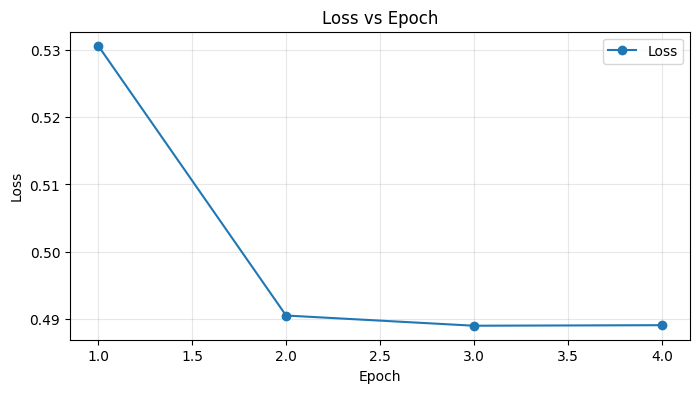

In [55]:
trainer = torch.optim.Adagrad
train_concise_ch11(trainer, {'lr': 0.1}, data_iter)

# RMSProp

Text(0.5, 0, 'time')

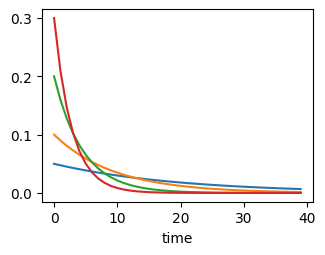

In [56]:
plt.figure(figsize=(3.5, 2.5))
gammas = [0.95, 0.9, 0.8, 0.7]
for gamma in gammas:
    x = torch.arange(40).detach().numpy()
    plt.plot(x, (1-gamma) * gamma ** x, label=f'gamma = {gamma:.2f}')
plt.xlabel('time')

## Implementation From Scratch

epoch 20, x1: -0.010599, x2: 0.000000


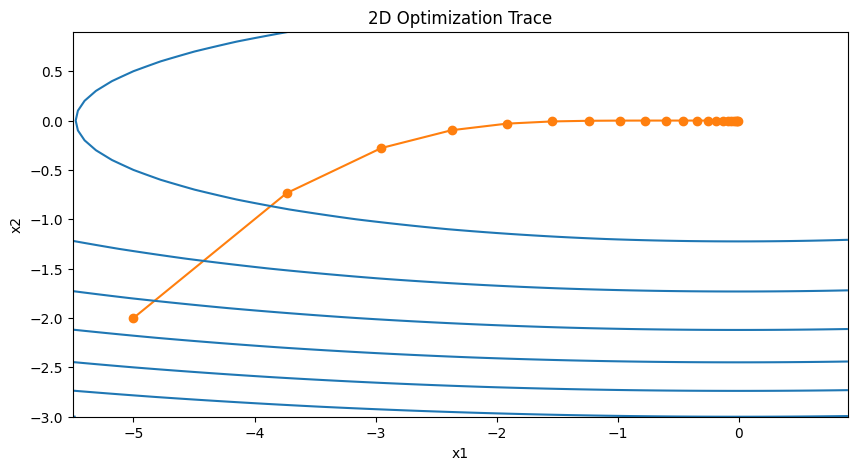

In [57]:
def rmsprop_2d(x1, x2, s1, s2):
    g1, g2, eps = 0.2 * x1, 4 * x2, 1e-6
    s1 = gamma * s1 + (1 - gamma) * g1 ** 2
    s2 = gamma * s2 + (1 - gamma) * g2 ** 2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

eta, gamma = 0.4, 0.9
show_trace_2d(f_2d, train_2d(rmsprop_2d))

In [60]:
def init_rmsprop_states(feature_dim):
    s_w = torch.zeros((feature_dim, 1))
    s_b = torch.zeros(1)
    return (s_w, s_b)

def rmsprop(params, states, hyperparams):
    gamma, eps = hyperparams['gamma'], 1e-6
    for p, s in zip(params, states):
        with torch.no_grad():
            s[:] = gamma * s + (1 - gamma) * torch.square(p.grad)
            p[:] -= hyperparams['lr'] * p.grad / torch.sqrt(s + eps)
        p.grad.data.zero_()

Training for 2 epochs...
  Step 5: Loss = 0.2507
  Step 10: Loss = 0.2456
  Step 15: Loss = 0.2449
Final loss: 0.245, 0.070 sec/epoch


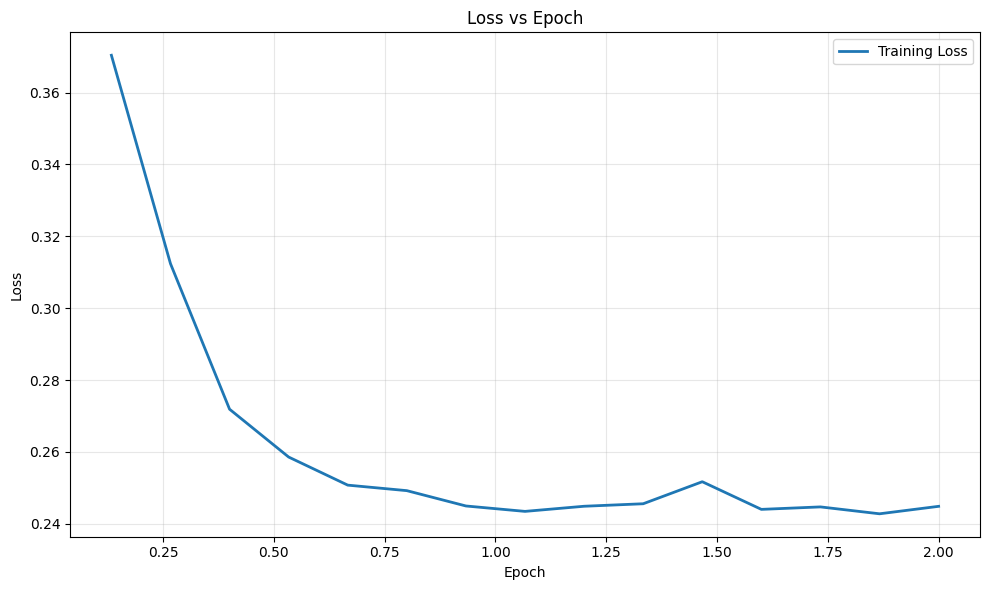

In [61]:
data_iter, feature_dim = get_data_ch11(batch_size=10)
train_ch11(rmsprop, init_rmsprop_states(feature_dim),
               {'lr': 0.01, 'gamma': 0.9}, data_iter, feature_dim);

## Concise Implementation

Final loss: 0.493, 0.311 sec/epoch


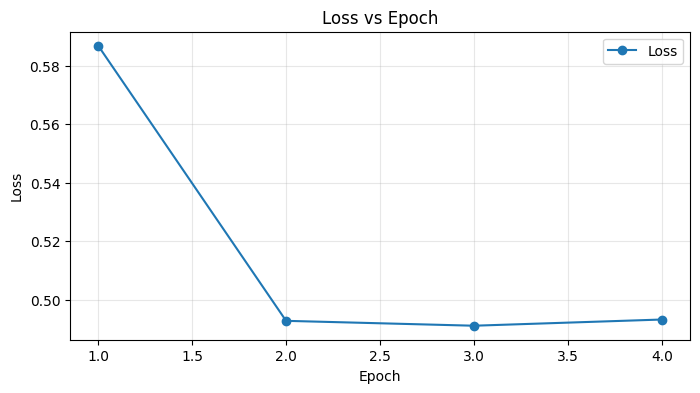

In [62]:
trainer = torch.optim.RMSprop
train_concise_ch11(trainer, {'lr': 0.01, 'alpha': 0.9},
                       data_iter)

# AdaDelta

AdaDelta is a variant of AdaGrad where the main difference is that it decreases the amount by which the learning rate is adaptive to coordinates. It uses 2 state variables $\vec{s_t}$ and $\Delta\vec{x_t}$ which are the leaky average of the 2nd moment of the gradient and the leaky average of the 2nd momnet of change of paramaters in the model respectively

## Implementation From Scratch

In [63]:
def init_adadelta_states(feature_dim):
    s_w, s_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    delta_w, delta_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    return ((s_w, delta_w), (s_b, delta_b))

def adadelta(params, states, hyperparams):
    rho, eps = hyperparams['rho'], 1e-6
    for p, (s, delta) in zip(params, states):
        with torch.no_grad():
            g = p.grad
            s[:] = rho * s + (1 - rho) * g**2
            update = torch.sqrt(delta + eps) / torch.sqrt(s + eps) * g
            p -= update
            delta[:] = rho * delta + (1 - rho) * update**2
        p.grad.data.zero_()

Training for 2 epochs...
  Step 5: Loss = 0.3405
  Step 10: Loss = 0.2803
  Step 15: Loss = 0.2565
Final loss: 0.256, 0.078 sec/epoch


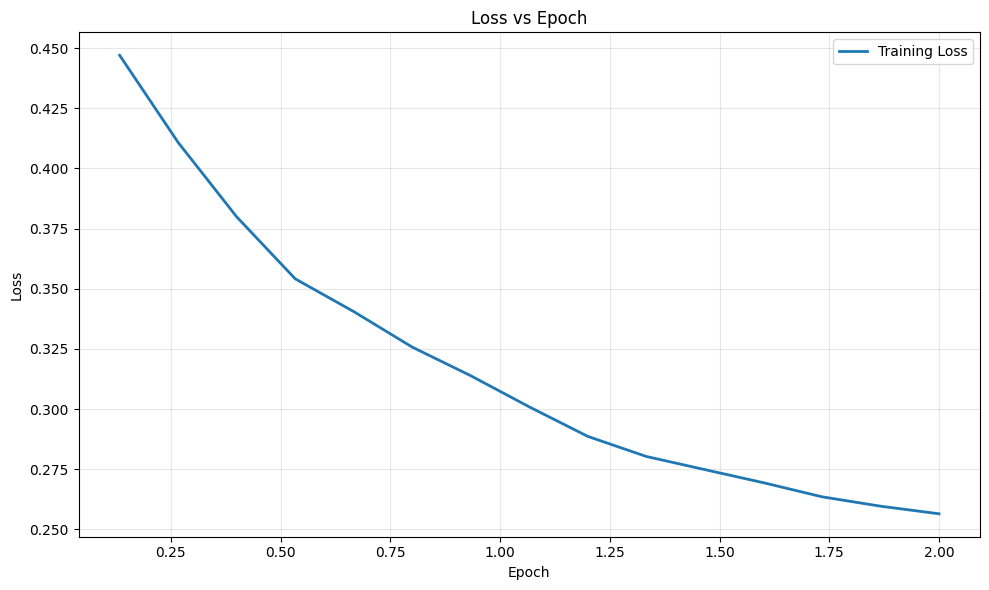

([0.011997222900390625,
  0.021997451782226562,
  0.031995534896850586,
  0.0429990291595459,
  0.05300474166870117,
  0.06300210952758789,
  0.07300782203674316,
  0.0830082893371582,
  0.09300875663757324,
  0.10301041603088379,
  0.1130070686340332,
  0.12300658226013184,
  0.13401007652282715,
  0.14401006698608398,
  0.1550149917602539,
  0.1550149917602539],
 [0.44703665375709534,
  0.410797655582428,
  0.37987571954727173,
  0.3541247248649597,
  0.34050002694129944,
  0.32573625445365906,
  0.31383568048477173,
  0.3008814752101898,
  0.2886196970939636,
  0.28027892112731934,
  0.2748119831085205,
  0.269374281167984,
  0.26352474093437195,
  0.259619802236557,
  0.25645774602890015])

In [64]:
data_iter, feature_dim = get_data_ch11(batch_size=10)
train_ch11(adadelta, init_adadelta_states(feature_dim),
          {'rho': 0.9}, data_iter, feature_dim)

## Concise Implementation

Final loss: 0.490, 0.323 sec/epoch


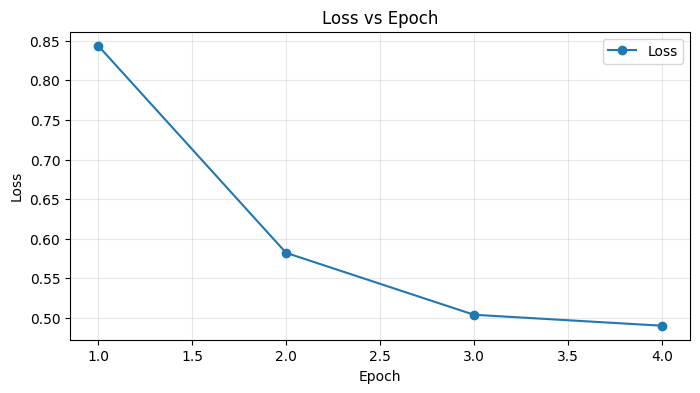

In [65]:
optimizer = torch.optim.Adadelta
train_concise_ch11(optimizer, {'rho': 0.9}, data_iter)

# Adam

Adam is an improvement from RMSProp and deviates from it very slightly. The renormalization term of $1/\sqrt{\vec{s_t} + \epsilon}$ changes to $1/(\sqrt{\vec{s_t}} + \epsilon)$. Also the update uses the moment estimate $\vec{v^{}_t}$ rather than the gradient itself from RMSProp

## Implementation From Scratch

In [66]:
def init_adam_states(feature_dim):
    v_w, v_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    s_w, s_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    return ((v_w, s_w), (v_b, s_b))

def adam(params, states, hyperparams):
    beta1, beta2, eps = 0.9, 0.999, 1e-6
    for p, (v, s) in zip(params, states):
        with torch.no_grad():
            v[:] = beta1 * v + (1 - beta1) * p.grad
            s[:] = beta2 * s + (1 - beta2) * torch.square(p.grad)
            v_bias_corr = v / (1 - beta1 ** hyperparams['t'])
            s_bias_corr = s / (1 - beta2 ** hyperparams['t'])
            p[:] -= hyperparams['lr'] * v_bias_corr / (torch.sqrt(s_bias_corr)
                                                       + eps)
        p.grad.data.zero_()
    hyperparams['t'] += 1

Training for 2 epochs...
  Step 5: Loss = 0.2452
  Step 10: Loss = 0.2437
  Step 15: Loss = 0.2474
Final loss: 0.247, 0.120 sec/epoch


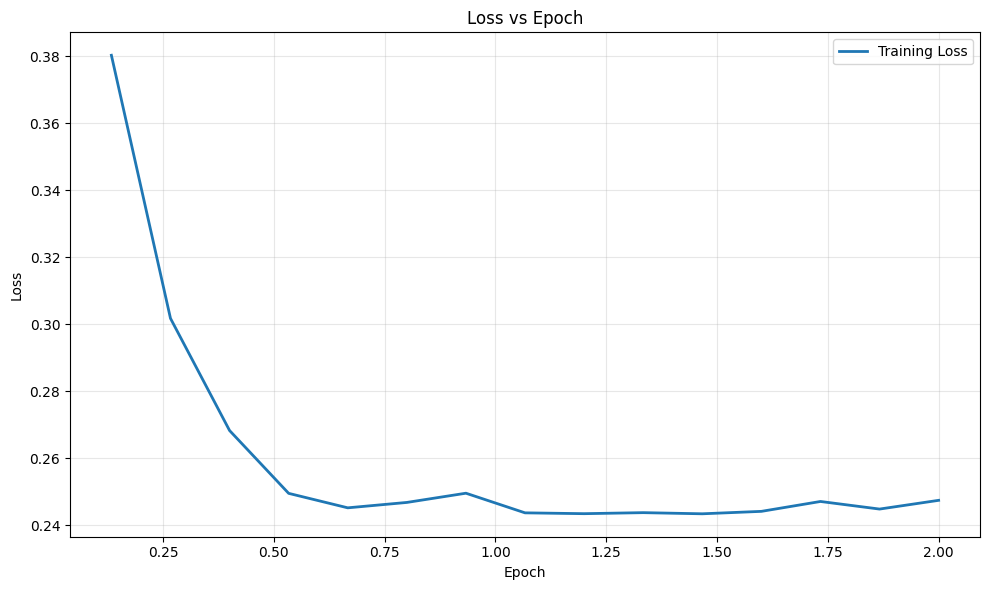

In [67]:
data_iter, feature_dim = get_data_ch11(batch_size=10)
train_ch11(adam, init_adam_states(feature_dim),
               {'lr': 0.01, 't': 1}, data_iter, feature_dim);

## Concise Implementation

Final loss: 0.491, 0.351 sec/epoch


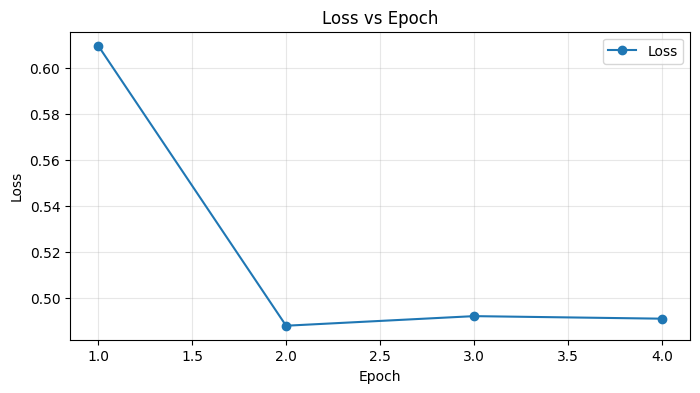

In [68]:
trainer = torch.optim.Adam
train_concise_ch11(trainer, {'lr': 0.01}, data_iter)

## Yogi

Due to high variance or sparse updates, the second moment may cause Adam to not converge, even in convex settings. To counter this, we have yogi that proposes to counter the magnitude of the update being dependent on the amount of deviation. Thus, the Yogi update: $\vec{s_{t}}$ <-- $\vec{s_{t-1}} + (1-\beta_2) \vec{g^2_t} \odot sgn(\vec{g^2_t} - \vec{s_{t-1}})$

Training for 2 epochs...
  Step 5: Loss = 0.4216
  Step 10: Loss = 0.3752
  Step 15: Loss = 0.3401
Final loss: 0.340, 0.079 sec/epoch


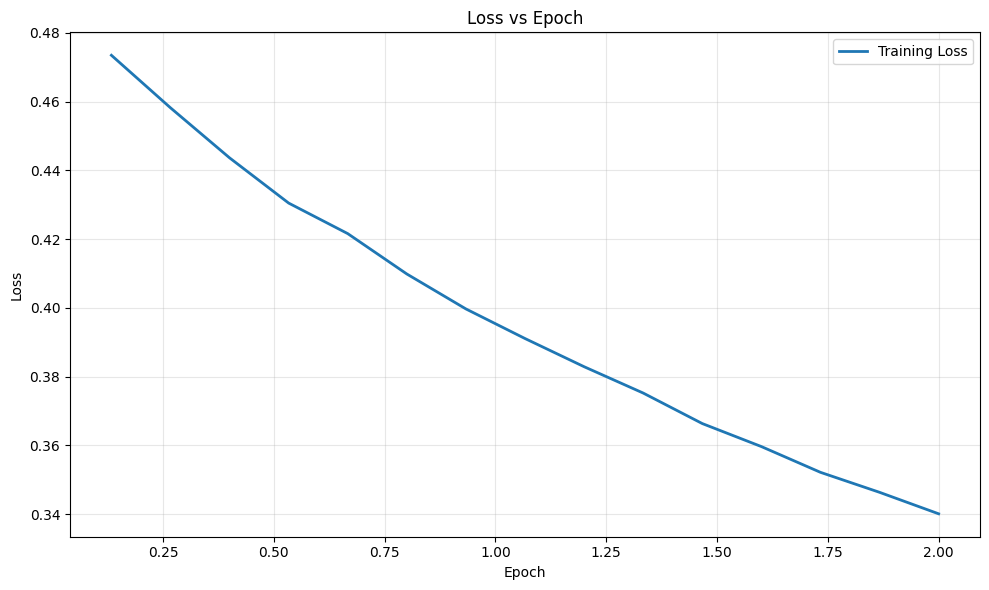

In [70]:
def yogi(params, states, hyperparams):
    beta1, beta2, eps = 0.9, 0.999, 1e-6
    for p, (v, s) in zip(params, states):
        with torch.no_grad():
            v = beta1 * v + (1 - beta1) * p.grad
            s += (1 - beta2) * torch.sign(torch.square(p.grad) - s) * torch.square(p.grad)
            v_bias_corr = v / (1 - beta1 ** hyperparams['t'])
            s_bias_corr = s / (1 - beta2 ** hyperparams['t'])
            p -= hyperparams['lr'] * v_bias_corr / (torch.sqrt(s_bias_corr) + eps)
        p.grad.data.zero_()
    hyperparams['t'] += 1


data_iter, feature_dim = get_data_ch11(batch_size=10)
train_ch11(yogi, init_adam_states(feature_dim), 
           {'lr': 0.01, 't': 1}, data_iter, feature_dim);

# Learning Rate Scheduling

Until now we have focused on how we update the gradients but can now focus on learning rate scheduling i.e. the rate at which we update the parameters. We can consider the magnitude of the learning rate (not too large as to diverge but not too small that it stops at a suboptimal solution), the rate of decay (We may keep bouncing around the minima due to large learning rate but decay can resolve this) and Warmup or initialization (How we intialize the parameters decides on how fast we converge to the optimal solution)

Let us look at an example of this

In [72]:
def net_fn():
    model = torch.nn.Sequential(
        torch.nn.Conv2d(1, 6, kernel_size=5, padding=2), torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=2, stride=2),
        torch.nn.Conv2d(6, 16, kernel_size=5), torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=2, stride=2),
        torch.nn.Flatten(),
        torch.nn.Linear(16 * 5 * 5, 120), torch.nn.ReLU(),
        torch.nn.Linear(120, 84), torch.nn.ReLU(),
        torch.nn.Linear(84, 10)
    )
    return model

In [73]:
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader

# Define the transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load Fashion-MNIST dataset
train_dataset = torchvision.datasets.FashionMNIST(root='./data', 
                                                 train=True,
                                                 transform=transform,
                                                 download=True)

test_dataset = torchvision.datasets.FashionMNIST(root='./data', 
                                                train=False,
                                                transform=transform,
                                                download=True)

# Create data loaders
batch_size = 256
train_iter = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_iter = DataLoader(test_dataset, batch_size=batch_size)

loss = torch.nn.CrossEntropyLoss()

100.0%
100.0%
100.0%
100.0%


In [81]:
size = lambda x, *args, **kwargs: x.numel(*args, **kwargs)

class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        """Defined in :numref:`sec_softmax_scratch`"""
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    
def accuracy(y_hat, y):
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.to(y.dtype) == y
    return float(cmp.sum())

def evaluate_accuracy_gpu(net, data_iter, device=None):
    """Compute the accuracy for a model on a dataset using a GPU.

    Defined in :numref:`sec_lenet`"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = Accumulator(2)

    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # Required for BERT Fine-tuning (to be covered later)
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(accuracy(net(X), y), size(y))
    return metric[0] / metric[1]


In [82]:
def train(net, train_iter, test_iter, num_epochs, trainer, device, scheduler=None):
    print("Training on", device)
    net.to(device)
    animator = Animator(xlabel='epoch', ylabel='loss',legend=['train_loss', 'train_acc', 'test_acc'])
    for epoch in range(num_epochs):
        metric = Accumulator(3)  # train_loss, train_acc, num_example
        for i, (X, y) in enumerate(train_iter):
            net.train()
            trainer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], (y_hat.argmax(dim=1) == y).sum().item(), X.shape[0])
            train_loss = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % 50 == 0:
                animator.add(epoch + i / len(train_iter),
                             (train_loss, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter, device)
        animator.add(epoch + 1, (None, None, test_acc))
        if scheduler:
            if scheduler.__module__ == lr_scheduler.__name__:
                # Using PyTorch In-Built scheduler
                scheduler.step()
            else:
                # Using custom defined scheduler
                for param_group in trainer.param_groups:
                    param_group['lr'] = scheduler(epoch)
        print(f'train loss {train_loss:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')

Training on cuda
epoch 1, train loss 0.979, train acc 0.635, test acc 0.739
epoch 2, train loss 0.466, train acc 0.825, test acc 0.757
epoch 3, train loss 0.384, train acc 0.857, test acc 0.793
epoch 4, train loss 0.341, train acc 0.872, test acc 0.868
epoch 5, train loss 0.313, train acc 0.882, test acc 0.853
epoch 6, train loss 0.294, train acc 0.889, test acc 0.880
epoch 7, train loss 0.279, train acc 0.896, test acc 0.872
epoch 8, train loss 0.263, train acc 0.902, test acc 0.883
epoch 9, train loss 0.254, train acc 0.905, test acc 0.884
epoch 10, train loss 0.242, train acc 0.908, test acc 0.894
epoch 11, train loss 0.233, train acc 0.913, test acc 0.880
epoch 12, train loss 0.225, train acc 0.914, test acc 0.872
epoch 13, train loss 0.219, train acc 0.917, test acc 0.885
epoch 14, train loss 0.208, train acc 0.921, test acc 0.883
epoch 15, train loss 0.200, train acc 0.924, test acc 0.892
epoch 16, train loss 0.195, train acc 0.926, test acc 0.895
epoch 17, train loss 0.188, trai

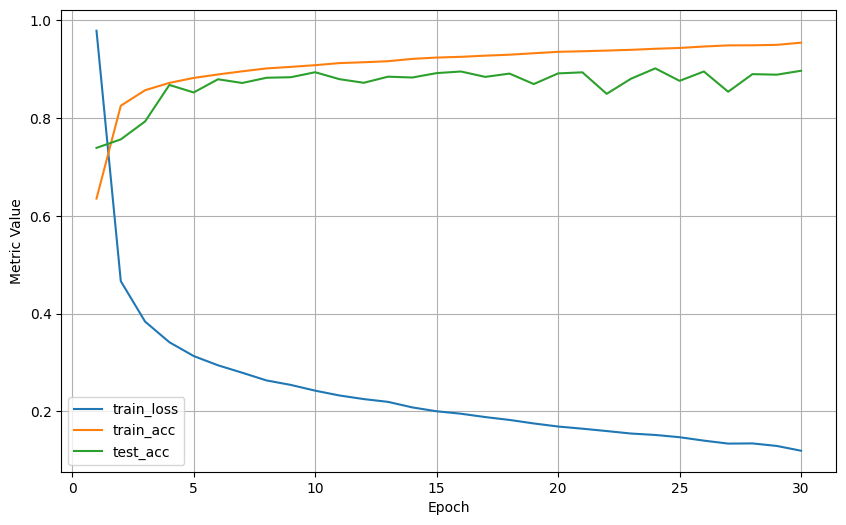

In [103]:
class Animator:  # Define a new Animator class that properly handles None values
	def __init__(self, xlabel=None, ylabel=None, legend=None):
		self.data = {'train_loss': [], 'train_acc': [], 'test_acc': []}
		self.epochs = []
		
	def add(self, epoch, metrics):
		self.epochs.append(epoch)
		train_loss, train_acc, test_acc = metrics
		if train_loss is not None:
			self.data['train_loss'].append(float(train_loss))
		if train_acc is not None:
			self.data['train_acc'].append(float(train_acc))
		if test_acc is not None:
			self.data['test_acc'].append(float(test_acc))
			
	def show(self):
		plt.figure(figsize=(10, 6))
		for label, values in self.data.items():
			if values:  # Only plot if we have data
				plt.plot(self.epochs[:len(values)], values, label=label)
		plt.xlabel('Epoch')
		plt.ylabel('Metric Value')
		plt.legend()
		plt.grid(True)
		plt.show()

def train(net, train_iter, test_iter, num_epochs, loss, trainer, device, scheduler=None):
	print("Training on", device)
	net.to(device)
	animator = Animator()
	
	for epoch in range(num_epochs):
		# Training phase
		net.train()
		train_loss_sum = 0
		train_acc_sum = 0
		n = 0
		for X, y in train_iter:
			X, y = X.to(device), y.to(device)
			trainer.zero_grad()
			y_hat = net(X)
			l = loss(y_hat, y)
			l.backward()
			trainer.step()
			
			train_loss_sum += l.item() * X.shape[0]
			train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
			n += X.shape[0]
			
		train_loss = train_loss_sum / n
		train_acc = train_acc_sum / n
		
		# Testing phase
		test_acc = evaluate_accuracy_gpu(net, test_iter, device)
		
		# Update learning rate using scheduler if provided
		if scheduler:
			if scheduler.__module__ == 'torch.optim.lr_scheduler':
				# Using PyTorch In-Built scheduler
				scheduler.step()
			else:
				# Using custom defined scheduler
				for param_group in trainer.param_groups:
					param_group['lr'] = scheduler(epoch)
		
		# Log the metrics
		animator.add(epoch + 1, (train_loss, train_acc, test_acc))
		print(f'epoch {epoch + 1}, train loss {train_loss:.3f}, '
			  f'train acc {train_acc:.3f}, test acc {test_acc:.3f}')
	
	animator.show()

lr, num_epochs = 0.3, 30
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=lr)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train(net, train_iter, test_iter, num_epochs, loss, trainer, device)

## Using a Scheduler

In [ ]:
lr = 0.1
trainer.param_groups[0]["lr"] = lr
print(f'learning rate is now {trainer.param_groups[0]["lr"]:.2f}')

learning rate is now 0.10


In [ ]:
class SquareRootScheduler:
    def __init__(self, lr=0.1):
        self.lr = lr

    def __call__(self, num_update):
        return self.lr * pow(num_update + 1.0, -0.5)

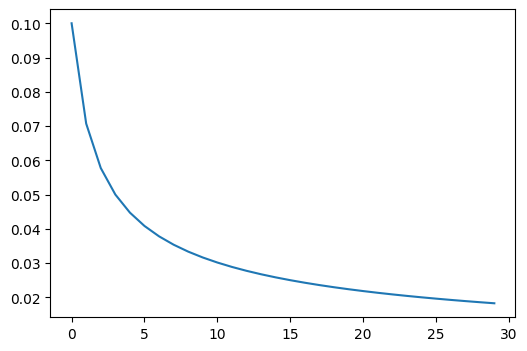

In [ ]:
scheduler = SquareRootScheduler(lr=0.1)
plt.figure(figsize=(6, 4))
plt.plot(torch.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

Training on cuda
epoch 1, train loss 1.038, train acc 0.613, test acc 0.745
epoch 2, train loss 0.486, train acc 0.818, test acc 0.774
epoch 3, train loss 0.395, train acc 0.854, test acc 0.859
epoch 4, train loss 0.347, train acc 0.870, test acc 0.851
epoch 5, train loss 0.317, train acc 0.882, test acc 0.876
epoch 6, train loss 0.294, train acc 0.891, test acc 0.881
epoch 7, train loss 0.274, train acc 0.899, test acc 0.886
epoch 8, train loss 0.261, train acc 0.903, test acc 0.884
epoch 9, train loss 0.247, train acc 0.909, test acc 0.870
epoch 10, train loss 0.236, train acc 0.913, test acc 0.890
epoch 11, train loss 0.223, train acc 0.917, test acc 0.884
epoch 12, train loss 0.212, train acc 0.921, test acc 0.897
epoch 13, train loss 0.202, train acc 0.926, test acc 0.896
epoch 14, train loss 0.193, train acc 0.928, test acc 0.896
epoch 15, train loss 0.184, train acc 0.932, test acc 0.889
epoch 16, train loss 0.178, train acc 0.935, test acc 0.902
epoch 17, train loss 0.170, trai

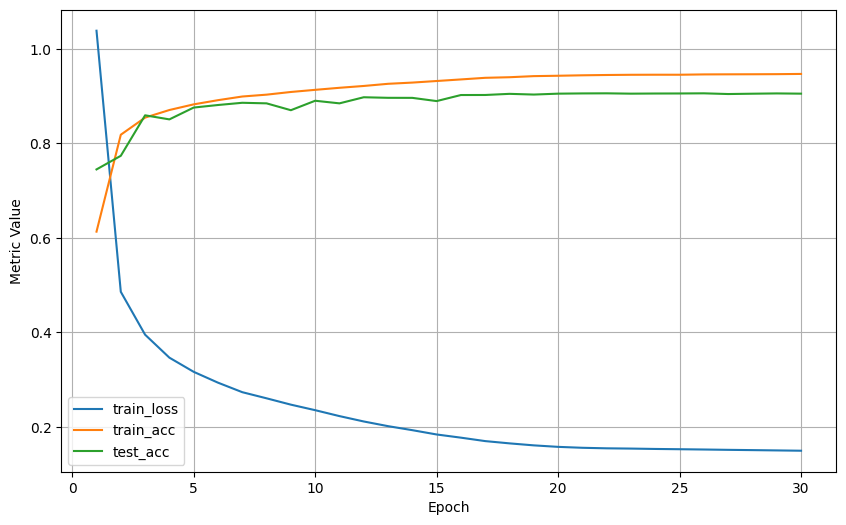

In [104]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
      scheduler)

## Factor Scheduler

An alternative to a polynomial rate scheduler is a multiplicative one. We use factor scheduling to change the learning rate with a reasonable lower bound

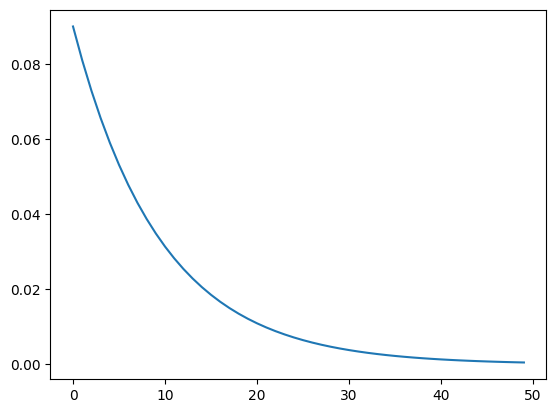

In [93]:
class FactorScheduler:
    def __init__(self, factor=1, stop_factor_lr=1e-7, base_lr = 0.1):
        self.factor = factor
        self.stop_factor_lr = stop_factor_lr
        self.base_lr = base_lr
    def __call__(self, num_updates):
        self.base_lr = max(self.base_lr * self.factor, self.stop_factor_lr)
        return self.base_lr
    
scheduler = FactorScheduler(factor=0.9, base_lr=0.1)
plt.plot(torch.arange(50), [scheduler(t) for t in range(50)])

## Multi Factor Scheduler

A common strategy for training of deep learning networks it to keep the learning rate piecewise constant and to decrease it by a certain amount ever so often

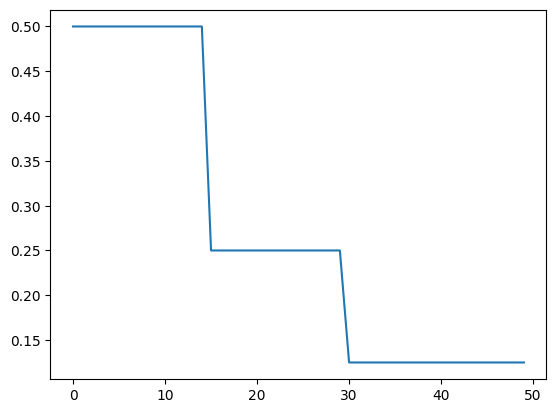

In [94]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
scheduler = lr_scheduler.MultiStepLR(trainer, milestones=[15, 30], gamma=0.5)

def get_lr(trainer, scheduler):
    lr = scheduler.get_last_lr()[0]
    trainer.step()
    scheduler.step()
    return lr
plt.plot(torch.arange(50), [get_lr(trainer, scheduler) for t in range(50)])

## Cosine Scheduler

Cosine schedulers were used after the observation was made that intial reduction of learning rate does not have to be steep and that final reduction of learning rate should end up with a small learning rate to reach the optimal solution

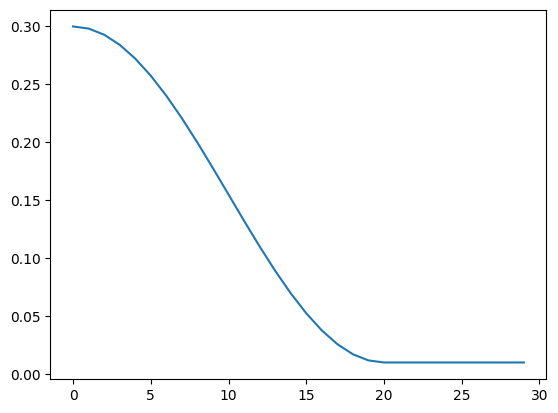

In [95]:
class CosineScheduler:
    def __init__(self, max_update, base_lr=0.01, final_lr=0,
               warmup_steps=0, warmup_begin_lr=0):
        self.base_lr_orig = base_lr
        self.max_update = max_update
        self.final_lr = final_lr
        self.warmup_steps = warmup_steps
        self.warmup_begin_lr = warmup_begin_lr
        self.max_steps = self.max_update - self.warmup_steps

    def get_warmup_lr(self, epoch):
        increase = (self.base_lr_orig - self.warmup_begin_lr) \
                       * float(epoch) / float(self.warmup_steps)
        return self.warmup_begin_lr + increase

    def __call__(self, epoch):
        if epoch < self.warmup_steps:
            return self.get_warmup_lr(epoch)
        if epoch <= self.max_update:
            self.base_lr = self.final_lr + (
                self.base_lr_orig - self.final_lr) * (1 + math.cos(
                math.pi * (epoch - self.warmup_steps) / self.max_steps)) / 2
        return self.base_lr

scheduler = CosineScheduler(max_update=20, base_lr=0.3, final_lr=0.01)
plt.plot(torch.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

Training on cuda
epoch 1, train loss 1.009, train acc 0.616, test acc 0.785
epoch 2, train loss 0.470, train acc 0.821, test acc 0.813
epoch 3, train loss 0.392, train acc 0.853, test acc 0.796
epoch 4, train loss 0.347, train acc 0.870, test acc 0.836
epoch 5, train loss 0.317, train acc 0.881, test acc 0.868
epoch 6, train loss 0.294, train acc 0.889, test acc 0.865
epoch 7, train loss 0.279, train acc 0.897, test acc 0.879
epoch 8, train loss 0.263, train acc 0.902, test acc 0.883
epoch 9, train loss 0.251, train acc 0.906, test acc 0.881
epoch 10, train loss 0.237, train acc 0.911, test acc 0.888
epoch 11, train loss 0.225, train acc 0.916, test acc 0.893
epoch 12, train loss 0.214, train acc 0.920, test acc 0.883
epoch 13, train loss 0.205, train acc 0.923, test acc 0.893
epoch 14, train loss 0.195, train acc 0.927, test acc 0.888
epoch 15, train loss 0.187, train acc 0.930, test acc 0.901
epoch 16, train loss 0.179, train acc 0.935, test acc 0.904
epoch 17, train loss 0.173, trai

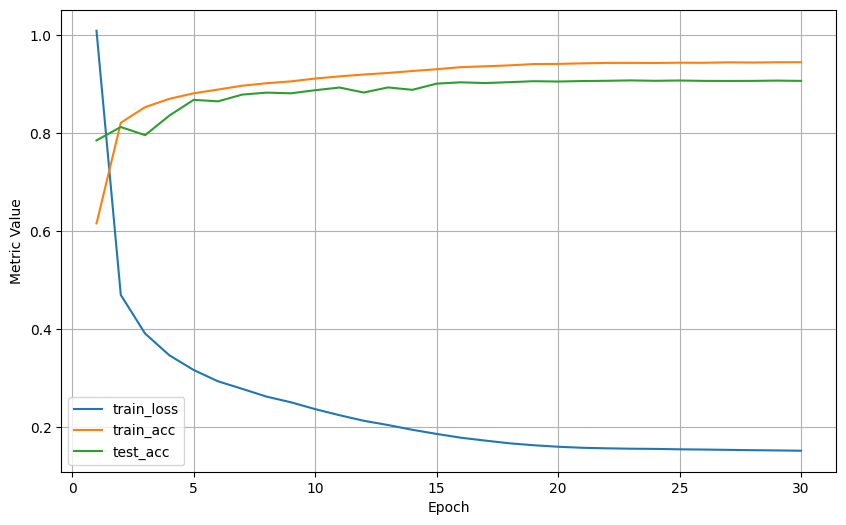

In [105]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=0.3)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
      scheduler)

## Warmup

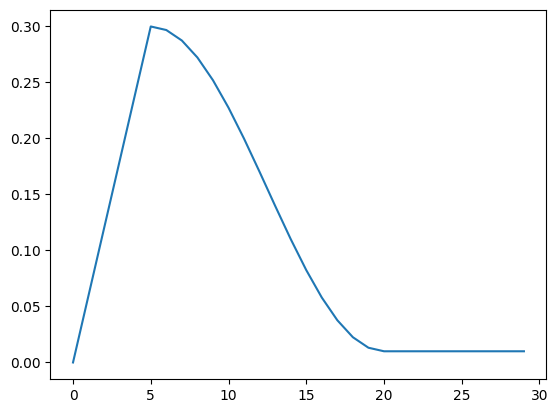

In [106]:
scheduler = CosineScheduler(20, warmup_steps=5, base_lr=0.3, final_lr=0.01)
plt.plot(torch.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

Training on cuda
epoch 1, train loss 1.051, train acc 0.612, test acc 0.709
epoch 2, train loss 0.752, train acc 0.711, test acc 0.709
epoch 3, train loss 0.470, train acc 0.822, test acc 0.822
epoch 4, train loss 0.432, train acc 0.839, test acc 0.830
epoch 5, train loss 0.402, train acc 0.852, test acc 0.829
epoch 6, train loss 0.377, train acc 0.859, test acc 0.852
epoch 7, train loss 0.354, train acc 0.867, test acc 0.855
epoch 8, train loss 0.320, train acc 0.880, test acc 0.871
epoch 9, train loss 0.298, train acc 0.888, test acc 0.861
epoch 10, train loss 0.278, train acc 0.895, test acc 0.867
epoch 11, train loss 0.262, train acc 0.901, test acc 0.881
epoch 12, train loss 0.246, train acc 0.907, test acc 0.883
epoch 13, train loss 0.235, train acc 0.912, test acc 0.888
epoch 14, train loss 0.221, train acc 0.916, test acc 0.894
epoch 15, train loss 0.209, train acc 0.922, test acc 0.897
epoch 16, train loss 0.199, train acc 0.926, test acc 0.893
epoch 17, train loss 0.189, trai

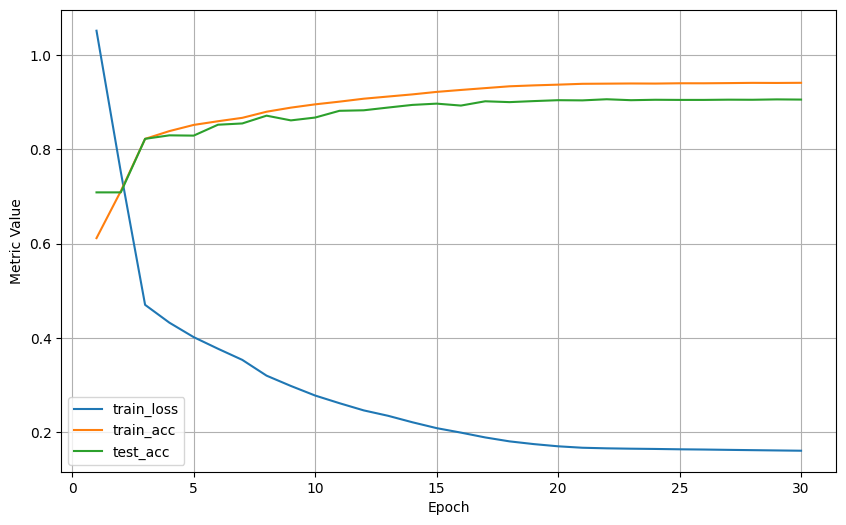

In [108]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=0.3)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
      scheduler)